## All views || Classifier || Training Classification model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Resnet

# Auto Encoder Feature Extraction

### No agumentation

Running on cuda

--- Data Loading ---
Full dataset loaded: 888 images.
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images
Val:   178 images
Test:  178 images
----------------------


=== Training Autoencoder ===
AE Epoch [1/30] - Loss: 0.0372
✅ Saved best Autoencoder (0.0372)
AE Epoch [2/30] - Loss: 0.0166
✅ Saved best Autoencoder (0.0166)
AE Epoch [3/30] - Loss: 0.0123
✅ Saved best Autoencoder (0.0123)
AE Epoch [4/30] - Loss: 0.0103
✅ Saved best Autoencoder (0.0103)
AE Epoch [5/30] - Loss: 0.0078
✅ Saved best Autoencoder (0.0078)
AE Epoch [6/30] - Loss: 0.0056
✅ Saved best Autoencoder (0.0056)
AE Epoch [7/30] - Loss: 0.0054
✅ Saved best Autoencoder (0.0054)
AE Epoch [8/30] - Loss: 0.0038
✅ Saved best Autoencoder (0.0038)
AE Epoch [9/30] - Loss: 0.0033
✅ Saved best Autoencoder (0.0033)
AE Epoch [10/30] - Loss: 0.0028
✅ Saved best Autoencoder (0.0028)
AE Epoch [11/30] - Loss: 0.0026
✅ Saved best Autoencoder (0.0026)
AE Epoch [12/30] - Loss: 0.0023
✅ Saved bes

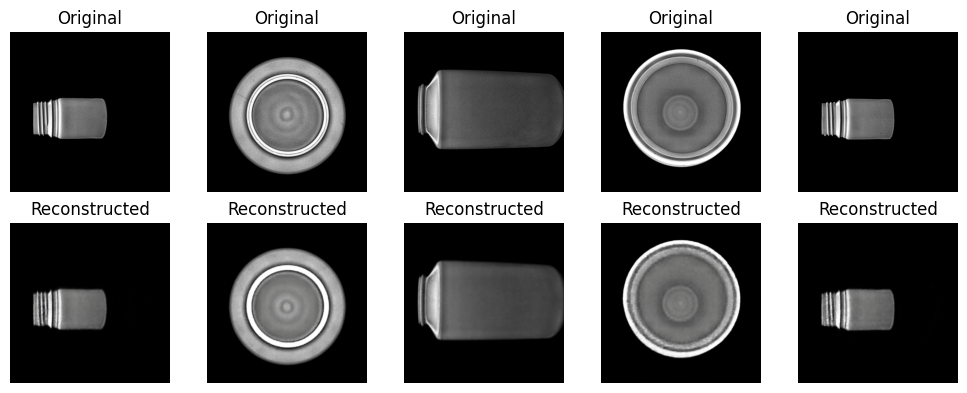


=== Extracting Latent Features ===
Train features shape: torch.Size([532, 256])
Val features shape:   torch.Size([178, 256])
Test features shape:  torch.Size([178, 256])

=== Training Classifier on Latent Vectors ===
Classifier Epoch [1/30] - Loss: 0.5042, Val Acc: 81.46%
✅ Saved best Classifier (Val Acc: 81.46%)
Classifier Epoch [2/30] - Loss: 0.4259, Val Acc: 78.65%
Classifier Epoch [3/30] - Loss: 0.3711, Val Acc: 80.34%
Classifier Epoch [4/30] - Loss: 0.3611, Val Acc: 80.34%
Classifier Epoch [5/30] - Loss: 0.3481, Val Acc: 76.40%
Classifier Epoch [6/30] - Loss: 0.3513, Val Acc: 78.09%
Classifier Epoch [7/30] - Loss: 0.3491, Val Acc: 78.65%
Classifier Epoch [8/30] - Loss: 0.3318, Val Acc: 76.97%
Classifier Epoch [9/30] - Loss: 0.3333, Val Acc: 78.09%
Classifier Epoch [10/30] - Loss: 0.3266, Val Acc: 78.65%
Classifier Epoch [11/30] - Loss: 0.3300, Val Acc: 79.78%
Classifier Epoch [12/30] - Loss: 0.3367, Val Acc: 77.53%
Classifier Epoch [13/30] - Loss: 0.3264, Val Acc: 74.72%
Classifi

In [ ]:
# ============================================
#  AUTOENCODER + CLASSIFIER (Corrected)
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset" # must have subfolders: defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0"

os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
LATENT_DIM = 256
EPOCHS_AE = 30
EPOCHS_RESNET = 30
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET AND NORMALIZATION [FIXED]
# ============================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 1. Load the full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
print(f"\n--- Data Loading ---")
print(f"Full dataset loaded: {len(full_dataset)} images.")

# Store class names for the final report
class_names = full_dataset.classes
print(f"Classes found: {full_dataset.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset.targets
# Create a list of indices [0, 1, 2, ..., n-1]
indices = list(range(len(targets)))

# 2. First split: (Train + Val) and Test (e.g., 80% / 20%)
# We use stratify=targets to ensure both sets get the same class distribution
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 3. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 4. Create the PyTorch Subset datasets
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)
test_data = Subset(full_dataset, test_indices)

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(full_dataset)} images")
print(f"Train: {len(train_data)} images")
print(f"Val:   {len(val_data)} images")
print(f"Test:  {len(test_data)} images")
print(f"----------------------\n")

# ============================================================
# 3 AUTOENCODER MODEL
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (IMG_SIZE // 8) * (IMG_SIZE // 8)), nn.ReLU(),
            nn.Unflatten(1, (128, IMG_SIZE // 8, IMG_SIZE // 8)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

autoencoder = Autoencoder(LATENT_DIM).to(DEVICE)

# ============================================================
# 4️ DENORMALIZATION HELPER
# ============================================================
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(1, 3, 1, 1).to(DEVICE)
        self.std = torch.tensor(std).view(1, 3, 1, 1).to(DEVICE)
    def __call__(self, x):
        return x * self.std + self.mean

denorm = Denormalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])

# ============================================================
# 5️ TRAIN AUTOENCODER
# ============================================================
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)
ae_path = os.path.join(SAVE_DIR, f"autoencoder_best_lat{LATENT_DIM}_img{IMG_SIZE}.pth")

print("\n=== Training Autoencoder ===")
best_loss = float("inf")
for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        # Note: The original code denormalized the target images for the loss.
        # This is a valid choice (reconstructing the original pixel values).
        recon, _ = autoencoder(imgs)
        loss = criterion_ae(recon, denorm(imgs))

        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"AE Epoch [{epoch+1}/{EPOCHS_AE}] - Loss: {avg_loss:.4f}")

    # Save best model based on training loss (or validation loss, if preferred)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE,
            "epochs": epoch+1
        }, ae_path)
        print(f" Saved best Autoencoder ({avg_loss:.4f})")

print(f" Final Autoencoder saved to {ae_path}")

# ============================================================
# 6️ VISUALIZE RECONSTRUCTION
# ============================================================
autoencoder.eval()
imgs, _ = next(iter(val_loader)) # Use validation loader for visualization
imgs = imgs.to(DEVICE)
with torch.no_grad():
    recon, _ = autoencoder(imgs)
recon = recon.detach().cpu()
orig = denorm(imgs).cpu().clamp(0,1)

fig, axes = plt.subplots(2, 5, figsize=(10,4))
for i in range(5):
    axes[0,i].imshow(orig[i].permute(1,2,0))
    axes[0,i].set_title("Original")
    axes[1,i].imshow(recon[i].permute(1,2,0))
    axes[1,i].set_title("Reconstructed")
    for ax in axes[:,i]: ax.axis("off")
plt.tight_layout()
plt.show()

# ============================================================
# 7️ FEATURE EXTRACTION USING ENCODER [UPDATED]
# ============================================================
def extract_features(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            features.append(z.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

print("\n=== Extracting Latent Features ===")
train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats, val_lbls = extract_features(autoencoder, val_loader)
test_feats, test_lbls = extract_features(autoencoder, test_loader) # <--- NEW

print(f"Train features shape: {train_feats.shape}")
print(f"Val features shape:   {val_feats.shape}")
print(f"Test features shape:  {test_feats.shape}")


# ============================================================
# 8️ CLASSIFIER (on latent vectors) [UPDATED]
# ============================================================

# --- IMPORTANT ---
# This is an MLP (Multi-Layer Perceptron), not ResNet18.
# Call it "MLP Classifier" in your thesis.
class LatentClassifier(nn.Module):
    def __init__(self, latent_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        return self.fc2(x)

latent_classifier = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = optim.Adam(latent_classifier.parameters(), lr=1e-3)
resnet_path = os.path.join(SAVE_DIR, f"classifier_best_lat{LATENT_DIM}_img{IMG_SIZE}.pth")


# Build latent loaders
class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, feats, lbls):
        self.feats, self.lbls = feats, lbls
    def __len__(self): return len(self.lbls)
    def __getitem__(self, i): return self.feats[i], self.lbls[i]

train_latent = DataLoader(LatentDataset(train_feats, train_lbls), batch_size=32, shuffle=True)
val_latent = DataLoader(LatentDataset(val_feats, val_lbls), batch_size=32)
test_latent = DataLoader(LatentDataset(test_feats, test_lbls), batch_size=32) # <--- NEW

print("\n=== Training Classifier on Latent Vectors ===")
best_acc = 0.0
for epoch in range(EPOCHS_RESNET):
    latent_classifier.train()
    total_loss = 0
    for x, y in train_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = latent_classifier(x)
        loss = criterion_clf(out, y)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_latent)

    # Validation accuracy
    latent_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_latent:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = latent_classifier(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    print(f"Classifier Epoch [{epoch+1}/{EPOCHS_RESNET}] - Loss: {avg_loss:.4f}, Val Acc: {acc:.2f}%")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": latent_classifier.state_dict(),
            "latent_dim": LATENT_DIM,
            "num_classes": NUM_CLASSES,
            "epochs": epoch+1
        }, resnet_path)
        print(f" Saved best Classifier (Val Acc: {acc:.2f}%)")

print(f" Final Classifier saved to {resnet_path}")

# ============================================================
# 9️ SAVE TRAINING SUMMARY
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary.json")
summary = {
    "autoencoder_best_loss": float(best_loss),
    "classifier_best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "epochs_resnet": EPOCHS_RESNET,
    "data_split": {
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f"\n Training summary saved to {summary_path}")


# ============================================================
# 1️0 FINAL EVALUATION ON TEST SET [NEW]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")

# 1. Load the best saved classifier model
final_model = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
checkpoint = torch.load(resnet_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)

        preds = final_model(x)
        all_preds.append(preds.argmax(1).cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
print(classification_report(all_labels, all_preds, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

print("\nFormat: (row = True Label, col = Predicted Label)")
print("          [Pred Good] [Pred Defective]")
print(f"[True Good] {cm[0,0]:>11} {cm[0,1]:>14}")
print(f"[True Defective] {cm[1,0]:>8} {cm[1,1]:>14}")

print("\n Evaluation complete.")

### with light agumentation

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (with augmentation)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------


=== Training Autoencoder (with rotation augmentation) ===
AE Epoch [1/30] - Loss: 0.0446
✅ Saved best Autoencoder (0.0446)
AE Epoch [2/30] - Loss: 0.0162
✅ Saved best Autoencoder (0.0162)
AE Epoch [3/30] - Loss: 0.0123
✅ Saved best Autoencoder (0.0123)
AE Epoch [4/30] - Loss: 0.0082
✅ Saved best Autoencoder (0.0082)
AE Epoch [5/30] - Loss: 0.0062
✅ Saved best Autoencoder (0.0062)
AE Epoch [6/30] - Loss: 0.0050
✅ Saved best Autoencoder (0.0050)
AE Epoch [7/30] - Loss: 0.0044
✅ Saved best Autoencoder (0.0044)
AE Epoch [8/30] - Loss: 0.0038
✅ Saved best Autoencoder (0.0038)
AE Epoch [9/30] - Loss: 0.0034
✅ Saved best Autoencoder (0.0034)
AE Epoch [10/30] - Loss: 0.0031
✅ Saved best Autoencoder (0.0031)
AE Epoch [11/30] - Loss: 0.0030
✅ Saved best Autoencoder 

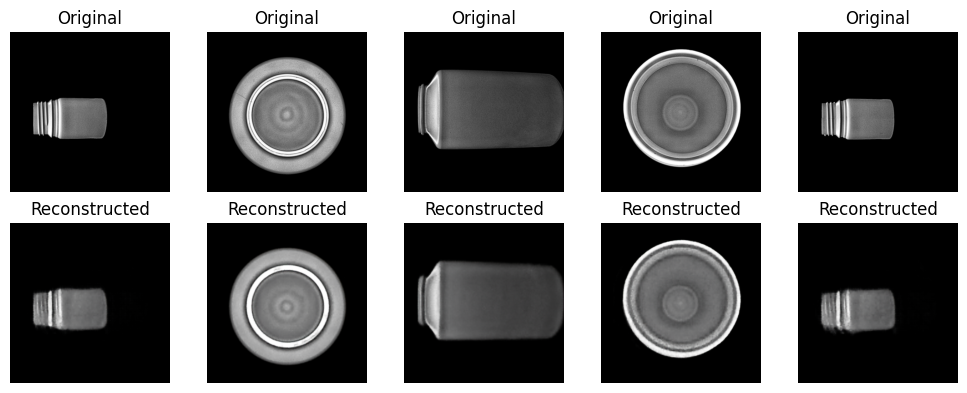


=== Extracting Latent Features ===
Train features shape: torch.Size([532, 256])
Val features shape:   torch.Size([178, 256])
Test features shape:  torch.Size([178, 256])

=== Training Classifier on Latent Vectors ===
Classifier Epoch [1/15] - Loss: 0.4917, Val Acc: 78.65%
✅ Saved best Classifier (Val Acc: 78.65%)
Classifier Epoch [2/15] - Loss: 0.4095, Val Acc: 77.53%
Classifier Epoch [3/15] - Loss: 0.4022, Val Acc: 79.78%
✅ Saved best Classifier (Val Acc: 79.78%)
Classifier Epoch [4/15] - Loss: 0.3981, Val Acc: 78.09%
Classifier Epoch [5/15] - Loss: 0.3785, Val Acc: 79.78%
Classifier Epoch [6/15] - Loss: 0.3865, Val Acc: 80.34%
✅ Saved best Classifier (Val Acc: 80.34%)
Classifier Epoch [7/15] - Loss: 0.3614, Val Acc: 78.65%
Classifier Epoch [8/15] - Loss: 0.3727, Val Acc: 78.09%
Classifier Epoch [9/15] - Loss: 0.3452, Val Acc: 78.65%
Classifier Epoch [10/15] - Loss: 0.3482, Val Acc: 79.21%
Classifier Epoch [11/15] - Loss: 0.3548, Val Acc: 80.90%
✅ Saved best Classifier (Val Acc: 80.9

In [ ]:
# ============================================
# 🔧 AUTOENCODER + CLASSIFIER (Corrected)
# With Light Rotation Augmentation (±10°)
# Author: Team Mosha / ChatGPT / Gemini
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # must have: defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/RESNET/light agumentation"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
LATENT_DIM = 256
EPOCHS_AE = 30
EPOCHS_CLASSIFIER = 15 # Renamed from EPOCHS_RESNET for clarity
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET AND NORMALIZATION [FIXED]
# ============================================================

# [FIX 1: Data Leakage]
# Create two separate transforms.
# Augmentation should ONLY be applied to the training set.
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=10),  # 🔹 Augmentation for training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
# Train data uses the AUGMENTED transform
train_data = Subset(train_dataset, train_indices)
# Val and Test data use the CLEAN (non-augmented) transform
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices)

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (with augmentation)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")

# ============================================================
# 3️ MODEL DEFINITIONS
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256, img_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 8) * (img_size // 8)), nn.ReLU(),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# --- IMPORTANT ---
# This is an MLP (Multi-Layer Perceptron), not ResNet18.
# Call it "MLP Classifier" in your thesis for accuracy.
class LatentClassifier(nn.Module):
    def __init__(self, latent_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        return self.fc2(x)

# ============================================================
# 4️⃣ DENORMALIZATION HELPER
# ============================================================
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(1, 3, 1, 1).to(DEVICE)
        self.std = torch.tensor(std).view(1, 3, 1, 1).to(DEVICE)
    def __call__(self, x):
        # Ensure x is on the same device as mean/std
        return x.to(DEVICE) * self.std + self.mean

denorm = Denormalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])

# ============================================================
# 5️ TRAIN AUTOENCODER
# ============================================================
autoencoder = Autoencoder(LATENT_DIM, IMG_SIZE).to(DEVICE)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)
ae_path = os.path.join(SAVE_DIR, f"autoencoder_best_lat{LATENT_DIM}_img{IMG_SIZE}.pth")

print("\n=== Training Autoencoder (with rotation augmentation) ===")
best_loss = float("inf")
for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        recon, _ = autoencoder(imgs)
        # Denormalize the original images (which are normalized) for the loss
        loss = criterion_ae(recon, denorm(imgs))
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"AE Epoch [{epoch+1}/{EPOCHS_AE}] - Loss: {avg_loss:.4f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE,
            "epochs": epoch+1
        }, ae_path)
        print(f"✅ Saved best Autoencoder ({avg_loss:.4f})")

print(f"✅ Final Autoencoder saved to {ae_path}")

# ============================================================
# 6️ VISUALIZE RECONSTRUCTION
# ============================================================
autoencoder.eval()
# Get images from val_loader (which has no augmentation) for a clean comparison
imgs, _ = next(iter(val_loader))
imgs = imgs.to(DEVICE)
with torch.no_grad():
    recon, _ = autoencoder(imgs)
recon = recon.detach().cpu()
orig = denorm(imgs).cpu().clamp(0,1)

fig, axes = plt.subplots(2, 5, figsize=(10,4))
for i in range(5):
    axes[0,i].imshow(orig[i].permute(1,2,0))
    axes[0,i].set_title("Original")
    axes[1,i].imshow(recon[i].permute(1,2,0))
    axes[1,i].set_title("Reconstructed")
    for ax in axes[:,i]: ax.axis("off")
plt.tight_layout()
plt.show()

# ============================================================
# 7️ FEATURE EXTRACTION USING ENCODER [UPDATED]
# ============================================================
def extract_features(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            features.append(z.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

print("\n=== Extracting Latent Features ===")
# Note: Features are extracted from the *augmented* train set
# and *clean* val and test sets. This is correct.
train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats, val_lbls = extract_features(autoencoder, val_loader)
test_feats, test_lbls = extract_features(autoencoder, test_loader) # <--- NEW

print(f"Train features shape: {train_feats.shape}")
print(f"Val features shape:   {val_feats.shape}")
print(f"Test features shape:  {test_feats.shape}")

# ============================================================
# 8️ TRAIN CLASSIFIER (on latent vectors) [UPDATED]
# ============================================================
latent_classifier = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = optim.Adam(latent_classifier.parameters(), lr=1e-3)
classifier_path = os.path.join(SAVE_DIR, f"classifier_best_lat{LATENT_DIM}_img{IMG_SIZE}.pth")


class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, feats, lbls):
        self.feats, self.lbls = feats, lbls
    def __len__(self): return len(self.lbls)
    def __getitem__(self, i): return self.feats[i], self.lbls[i]

train_latent = DataLoader(LatentDataset(train_feats, train_lbls), batch_size=32, shuffle=True)
val_latent = DataLoader(LatentDataset(val_feats, val_lbls), batch_size=32)
test_latent = DataLoader(LatentDataset(test_feats, test_lbls), batch_size=32) # <--- NEW

print("\n=== Training Classifier on Latent Vectors ===")
best_acc = 0.0
for epoch in range(EPOCHS_CLASSIFIER):
    latent_classifier.train()
    total_loss = 0
    for x, y in train_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = latent_classifier(x)
        loss = criterion_clf(out, y)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_latent)

    # Validation accuracy
    latent_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_latent:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = latent_classifier(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    print(f"Classifier Epoch [{epoch+1}/{EPOCHS_CLASSIFIER}] - Loss: {avg_loss:.4f}, Val Acc: {acc:.2f}%")

    # Save best classifier
    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": latent_classifier.state_dict(),
            "latent_dim": LATENT_DIM,
            "num_classes": NUM_CLASSES,
            "epochs": epoch+1
        }, classifier_path)
        print(f"✅ Saved best Classifier (Val Acc: {acc:.2f}%)")

print(f"✅ Final Classifier saved to {classifier_path}")

# ============================================================
# 9️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary.json")
summary = {
    "autoencoder_best_loss": float(best_loss),
    "classifier_best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "epochs_classifier": EPOCHS_CLASSIFIER,
    "augmentation": "RandomRotation ±10°",
    "data_split": {
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f" Training summary saved to {summary_path}")


# ============================================================
# 1️0️ FINAL EVALUATION ON TEST SET [NEW]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")

# 1. Load the best saved classifier model
final_model = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
checkpoint = torch.load(classifier_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)

        preds = final_model(x)
        all_preds.append(preds.argmax(1).cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
# and is the correct one to use for your thesis.
print(classification_report(all_labels, all_preds, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Assuming class 0 is 'defective' and class 1 is 'good' based on folder order
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm[0,0]:>11} {cm[0,1]:>14}")
print(f"[True {class_names[1]}] {cm[1,0]:>11} {cm[1,1]:>14}")

print("\n✅ Evaluation complete.")

### With Heavy agumentation

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (HEAVY augmentation)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------


=== Training Autoencoder (HEAVY augmentation) ===
AE Epoch [1/30] - Loss: 0.0417
✅ Saved best Autoencoder (0.0417)
AE Epoch [2/30] - Loss: 0.0221
✅ Saved best Autoencoder (0.0221)
AE Epoch [3/30] - Loss: 0.0166
✅ Saved best Autoencoder (0.0166)
AE Epoch [4/30] - Loss: 0.0154
✅ Saved best Autoencoder (0.0154)
AE Epoch [5/30] - Loss: 0.0127
✅ Saved best Autoencoder (0.0127)
AE Epoch [6/30] - Loss: 0.0115
✅ Saved best Autoencoder (0.0115)
AE Epoch [7/30] - Loss: 0.0097
✅ Saved best Autoencoder (0.0097)
AE Epoch [8/30] - Loss: 0.0095
✅ Saved best Autoencoder (0.0095)
AE Epoch [9/30] - Loss: 0.0090
✅ Saved best Autoencoder (0.0090)
AE Epoch [10/30] - Loss: 0.0086
✅ Saved best Autoencoder (0.0086)
AE Epoch [11/30] - Loss: 0.0085
✅ Saved best Autoencoder (0.0085

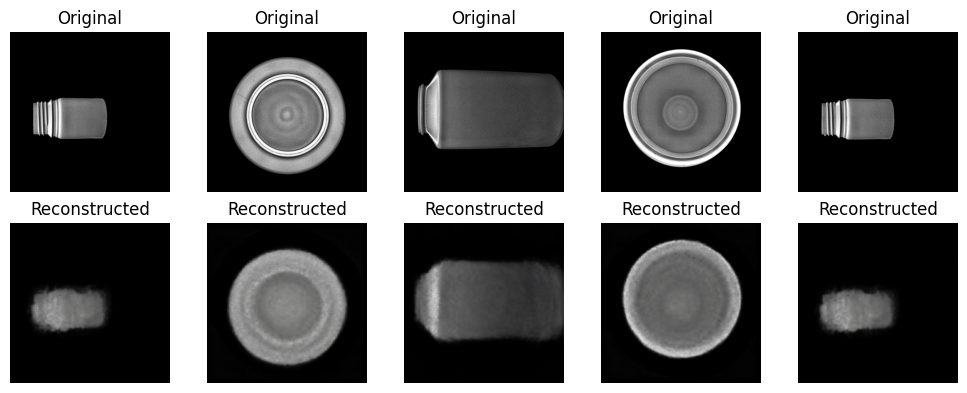


=== Extracting Latent Features ===
Train features shape: torch.Size([532, 256])
Val features shape:   torch.Size([178, 256])
Test features shape:  torch.Size([178, 256])

=== Training Classifier on Latent Vectors ===
Classifier Epoch [1/30] - Loss: 0.5533, Val Acc: 79.21%
✅ Saved best Classifier (Val Acc: 79.21%)
Classifier Epoch [2/30] - Loss: 0.4172, Val Acc: 80.34%
✅ Saved best Classifier (Val Acc: 80.34%)
Classifier Epoch [3/30] - Loss: 0.4113, Val Acc: 79.21%
Classifier Epoch [4/30] - Loss: 0.3732, Val Acc: 80.34%
Classifier Epoch [5/30] - Loss: 0.3669, Val Acc: 79.21%
Classifier Epoch [6/30] - Loss: 0.3723, Val Acc: 80.34%
Classifier Epoch [7/30] - Loss: 0.3576, Val Acc: 79.21%
Classifier Epoch [8/30] - Loss: 0.3440, Val Acc: 80.34%
Classifier Epoch [9/30] - Loss: 0.3434, Val Acc: 78.09%
Classifier Epoch [10/30] - Loss: 0.3437, Val Acc: 79.21%
Classifier Epoch [11/30] - Loss: 0.3509, Val Acc: 78.09%
Classifier Epoch [12/30] - Loss: 0.3468, Val Acc: 80.90%
✅ Saved best Classifier

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # must have: defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/RESNET/heavy agumentation"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
LATENT_DIM = 256
EPOCHS_AE = 30
EPOCHS_CLASSIFIER = 30 # Renamed from EPOCHS_RESNET
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET AND NORMALIZATION (HEAVY AUGMENTATION) [FIXED]
# ============================================================

# [FIX 1: Data Leakage]
# Create two separate transforms.
# Augmentation should ONLY be applied to the training set.
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=15),          # wider ±15° rotations
    transforms.RandomHorizontalFlip(p=0.5),         # random left-right flip
    transforms.RandomVerticalFlip(p=0.2),           # occasional top-bottom flip
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1)),  # small shifts + zoom
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),  # mild perspective distortion
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
# Train data uses the AUGMENTED transform
train_data = Subset(train_dataset, train_indices)
# Val and Test data use the CLEAN (non-augmented) transform
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices)

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (HEAVY augmentation)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")

# ============================================================
# 3️ MODEL DEFINITIONS
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256, img_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 8) * (img_size // 8)), nn.ReLU(),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# --- IMPORTANT ---
# This is an MLP (Multi-Layer Perceptron), not ResNet18.
# Call it "MLP Classifier" in your thesis for accuracy.
class LatentClassifier(nn.Module):
    def __init__(self, latent_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        return self.fc2(x)

# ============================================================
# 4️ DENORMALIZATION HELPER
# ============================================================
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(1, 3, 1, 1).to(DEVICE)
        self.std = torch.tensor(std).view(1, 3, 1, 1).to(DEVICE)
    def __call__(self, x):
        # Ensure x is on the same device as mean/std
        return x.to(DEVICE) * self.std + self.mean

denorm = Denormalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])

# ============================================================
# 5️ TRAIN AUTOENCODER
# ============================================================
autoencoder = Autoencoder(LATENT_DIM, IMG_SIZE).to(DEVICE)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)
ae_path = os.path.join(SAVE_DIR, f"autoencoder_best_HEAVY_lat{LATENT_DIM}_img{IMG_SIZE}.pth")

print("\n=== Training Autoencoder (HEAVY augmentation) ===")
best_loss = float("inf")
for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        recon, _ = autoencoder(imgs)
        # Denormalize the original images (which are normalized) for the loss
        loss = criterion_ae(recon, denorm(imgs))
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"AE Epoch [{epoch+1}/{EPOCHS_AE}] - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE,
            "epochs": epoch+1
        }, ae_path)
        print(f"✅ Saved best Autoencoder ({avg_loss:.4f})")

print(f"✅ Final Autoencoder saved to {ae_path}")

# ============================================================
# 6️ VISUALIZE RECONSTRUCTION
# ============================================================
autoencoder.eval()
# Get images from val_loader (which has no augmentation) for a clean comparison
imgs, _ = next(iter(val_loader))
imgs = imgs.to(DEVICE)
with torch.no_grad():
    recon, _ = autoencoder(imgs)
recon = recon.detach().cpu()
orig = denorm(imgs).cpu().clamp(0,1)

fig, axes = plt.subplots(2, 5, figsize=(10,4))
for i in range(5):
    axes[0,i].imshow(orig[i].permute(1,2,0))
    axes[0,i].set_title("Original")
    axes[1,i].imshow(recon[i].permute(1,2,0))
    axes[1,i].set_title("Reconstructed")
    for ax in axes[:,i]: ax.axis("off")
plt.tight_layout()
plt.show()

# ============================================================
# 7️ FEATURE EXTRACTION USING ENCODER [UPDATED]
# ============================================================
def extract_features(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            features.append(z.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

print("\n=== Extracting Latent Features ===")
# Note: Features are extracted from the *augmented* train set
# and *clean* val and test sets. This is correct.
train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats, val_lbls = extract_features(autoencoder, val_loader)
test_feats, test_lbls = extract_features(autoencoder, test_loader) # <--- NEW

print(f"Train features shape: {train_feats.shape}")
print(f"Val features shape:   {val_feats.shape}")
print(f"Test features shape:  {test_feats.shape}")

# ============================================================
# 8️ TRAIN CLASSIFIER (on latent vectors) [UPDATED]
# ============================================================
latent_classifier = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = optim.Adam(latent_classifier.parameters(), lr=1e-3)
classifier_path = os.path.join(SAVE_DIR, f"classifier_best_HEAVY_lat{LATENT_DIM}_img{IMG_SIZE}.pth")


class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, feats, lbls):
        self.feats, self.lbls = feats, lbls
    def __len__(self): return len(self.lbls)
    def __getitem__(self, i): return self.feats[i], self.lbls[i]

train_latent = DataLoader(LatentDataset(train_feats, train_lbls), batch_size=32, shuffle=True)
val_latent = DataLoader(LatentDataset(val_feats, val_lbls), batch_size=32)
test_latent = DataLoader(LatentDataset(test_feats, test_lbls), batch_size=32) # <--- NEW

print("\n=== Training Classifier on Latent Vectors ===")
best_acc = 0.0
for epoch in range(EPOCHS_CLASSIFIER):
    latent_classifier.train()
    total_loss = 0
    for x, y in train_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = latent_classifier(x)
        loss = criterion_clf(out, y)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_latent)

    # Validation accuracy
    latent_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_latent:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = latent_classifier(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    print(f"Classifier Epoch [{epoch+1}/{EPOCHS_CLASSIFIER}] - Loss: {avg_loss:.4f}, Val Acc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": latent_classifier.state_dict(),
            "latent_dim": LATENT_DIM,
            "num_classes": NUM_CLASSES,
            "epochs": epoch+1
        }, classifier_path)
        print(f"✅ Saved best Classifier (Val Acc: {acc:.2f}%)")

print(f"✅ Final Classifier saved to {classifier_path}")

# ============================================================
# 9️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_HEAVY.json")
summary = {
    "autoencoder_best_loss": float(best_loss),
    "classifier_best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "epochs_classifier": EPOCHS_CLASSIFIER,
    "augmentation": "Heavy (Rotation ±15°, Flip, ColorJitter, Affine, Perspective)",
    "data_split": {
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f" Training summary saved to {summary_path}")


# ============================================================
# 1️0️ FINAL EVALUATION ON TEST SET [NEW]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")

# 1. Load the best saved classifier model
final_model = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
checkpoint = torch.load(classifier_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)

        preds = final_model(x)
        all_preds.append(preds.argmax(1).cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
# and is the correct one to use for your thesis.
print(classification_report(all_labels, all_preds, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Assuming class 0 is 'defective' and class 1 is 'good' based on folder order
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm[0,0]:>11} {cm[0,1]:>14}")
print(f"[True {class_names[1]}] {cm[1,0]:>11} {cm[1,1]:>14}")

print("\n✅ Evaluation complete.")

# MobinetV2

### No agumentation

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # must have: defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/MOBIVNET/No agumentation"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
LATENT_DIM = 256
EPOCHS_AE = 30
EPOCHS_CLASSIFIER = 30 # Renamed from EPOCHS_MOBILENET
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET AND NORMALIZATION (NO AUGMENTATION) [FIXED]
# ============================================================

# [FIX 1: Data Leakage Structure]
# Define two separate transforms, even for no-aug, to maintain a correct pipeline.
# Augmentation should ONLY be applied to the training set (transform_train).
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
train_data = Subset(train_dataset, train_indices)
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices)

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (NO augmentation)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")

# ============================================================
# 3️ AUTOENCODER DEFINITION
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256, img_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 8) * (img_size // 8)), nn.ReLU(),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# ============================================================
# 4️ DENORMALIZATION HELPER [NEW, WAS MISSING]
# ============================================================
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(1, 3, 1, 1).to(DEVICE)
        self.std = torch.tensor(std).view(1, 3, 1, 1).to(DEVICE)
    def __call__(self, x):
        # Ensure x is on the same device as mean/std
        return x.to(DEVICE) * self.std + self.mean

denorm = Denormalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])

# ============================================================
# 5️ TRAIN AUTOENCODER [FIXED]
# ============================================================
autoencoder = Autoencoder(LATENT_DIM, IMG_SIZE).to(DEVICE)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)
best_loss = float("inf")
ae_path = os.path.join(SAVE_DIR, "autoencoder_best_NOAUG.pth")

print("\n=== Training Autoencoder (NO augmentation) ===")
for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        recon, _ = autoencoder(imgs)

        # [FIX] Loss must be between recon (Sigmoid 0-1) and *denormalized* images (Pixel 0-1)
        # Your original code was: loss = criterion(recon, imgs) which is incorrect.
        loss = criterion_ae(recon, denorm(imgs))

        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"AE Epoch [{epoch+1}/{EPOCHS_AE}] - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE,
            "epochs": epoch+1
        }, ae_path)
        print(f"✅ Saved best Autoencoder ({avg_loss:.4f})")

print(f"✅ Final Autoencoder saved to {ae_path}")

# ============================================================
# 6️ FEATURE EXTRACTION [UPDATED]
# ============================================================
def extract_features(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            features.append(z.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

print("\n=== Extracting Latent Features ===")
train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats, val_lbls = extract_features(autoencoder, val_loader)
test_feats, test_lbls = extract_features(autoencoder, test_loader) # <--- NEW

print(f"Train features shape: {train_feats.shape}")
print(f"Val features shape:   {val_feats.shape}")
print(f"Test features shape:  {test_feats.shape}")

# ============================================================
# 7️ CLASSIFIER (Latent Head) [UPDATED]
# ============================================================

# --- IMPORTANT ---
# This is an MLP (Multi-Layer Perceptron), not MobileNetV2.
# Call it "MLP Classifier" in your thesis for accuracy.
class LatentClassifier(nn.Module):
    def __init__(self, latent_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.act1 = nn.ReLU6(inplace=True)
        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU6(inplace=True)
        self.fc3 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.act2(self.bn2(self.fc2(x)))
        return self.fc3(x)

latent_classifier = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = optim.Adam(latent_classifier.parameters(), lr=1e-3)
classifier_path = os.path.join(SAVE_DIR, "classifier_best_NOAUG.pth") # Renamed

class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, feats, lbls):
        self.feats, self.lbls = feats, lbls
    def __len__(self): return len(self.lbls)
    def __getitem__(self, i): return self.feats[i], self.lbls[i]

train_latent = DataLoader(LatentDataset(train_feats, train_lbls), batch_size=32, shuffle=True)
val_latent = DataLoader(LatentDataset(val_feats, val_lbls), batch_size=32)
test_latent = DataLoader(LatentDataset(test_feats, test_lbls), batch_size=32) # <--- NEW

# ============================================================
# 8️ TRAIN CLASSIFIER [UPDATED]
# ============================================================
print("\n=== Training MLP Classifier on Latent Features (NO augmentation) ===")
best_acc = 0.0
for epoch in range(EPOCHS_CLASSIFIER):
    latent_classifier.train()
    total_loss = 0
    for x, y in train_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = latent_classifier(x)
        loss = criterion_clf(out, y)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_latent)

    latent_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_latent:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = latent_classifier(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    print(f"Classifier Epoch [{epoch+1}/{EPOCHS_CLASSIFIER}] - Loss: {avg_loss:.4f}, Val Acc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": latent_classifier.state_dict(),
            "latent_dim": LATENT_DIM,
            "num_classes": NUM_CLASSES,
            "epochs": epoch+1
        }, classifier_path)
        print(f"✅ Saved best Classifier (Val Acc: {acc:.2f}%)")

print(f"✅ Final Classifier saved to {classifier_path}")

# ============================================================
# 9️ SAVE SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_MLP_NOAUG.json")
summary = {
    "autoencoder_best_loss": float(best_loss),
    "classifier_best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "epochs_classifier": EPOCHS_CLASSIFIER,
    "augmentation": "None (Baseline)",
    "data_split": {
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f"\n Training summary saved to {summary_path}")

# ============================================================
# 1️0️ FINAL EVALUATION ON TEST SET [NEW]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")

# 1. Load the best saved classifier model
final_model = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
checkpoint = torch.load(classifier_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)

        preds = final_model(x)
        all_preds.append(preds.argmax(1).cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
# and is the correct one to use for your thesis.
print(classification_report(all_labels, all_preds, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Assuming class 0 is 'defective' and class 1 is 'good' based on folder order
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm[0,0]:>11} {cm[0,1]:>14}")
print(f"[True {class_names[1]}] {cm[1,0]:>11} {cm[1,1]:>14}")

print("\n✅ Evaluation complete.")

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (NO augmentation)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------


=== Training Autoencoder (NO augmentation) ===
AE Epoch [1/30] - Loss: 0.0421
✅ Saved best Autoencoder (0.0421)
AE Epoch [2/30] - Loss: 0.0153
✅ Saved best Autoencoder (0.0153)
AE Epoch [3/30] - Loss: 0.0115
✅ Saved best Autoencoder (0.0115)
AE Epoch [4/30] - Loss: 0.0097
✅ Saved best Autoencoder (0.0097)
AE Epoch [5/30] - Loss: 0.0077
✅ Saved best Autoencoder (0.0077)
AE Epoch [6/30] - Loss: 0.0057
✅ Saved best Autoencoder (0.0057)
AE Epoch [7/30] - Loss: 0.0051
✅ Saved best Autoencoder (0.0051)
AE Epoch [8/30] - Loss: 0.0040
✅ Saved best Autoencoder (0.0040)
AE Epoch [9/30] - Loss: 0.0034
✅ Saved best Autoencoder (0.0034)
AE Epoch [10/30] - Loss: 0.0029
✅ Saved best Autoencoder (0.0029)
AE Epoch [11/30] - Loss: 0.0027
✅ Saved best Autoencoder (0.0027)
AE E

###  light agumentation

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # folders: defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/MOBIVNET/light agumentation"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
LATENT_DIM = 256
EPOCHS_AE = 30
EPOCHS_CLASSIFIER = 30 # Renamed from EPOCHS_MOBILENET
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET + ROTATION-ONLY AUGMENTATION [FIXED]
# ============================================================

# [FIX 1: Data Leakage]
# Create two separate transforms.
# Augmentation should ONLY be applied to the training set.
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=5),  # 🔹 ±5° rotation only
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
# Train data uses the AUGMENTED transform
train_data = Subset(train_dataset, train_indices)
# Val and Test data use the CLEAN (non-augmented) transform
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices)

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (Rotation-Only ±5°)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")

# ============================================================
# 3️ AUTOENCODER DEFINITION
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256, img_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 8) * (img_size // 8)), nn.ReLU(),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# ============================================================
# 4️ DENORMALIZATION HELPER [NEW, WAS MISSING]
# ============================================================
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(1, 3, 1, 1).to(DEVICE)
        self.std = torch.tensor(std).view(1, 3, 1, 1).to(DEVICE)
    def __call__(self, x):
        # Ensure x is on the same device as mean/std
        return x.to(DEVICE) * self.std + self.mean

denorm = Denormalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])

# ============================================================
# 5️ TRAIN AUTOENCODER [FIXED]
# ============================================================
autoencoder = Autoencoder(LATENT_DIM, IMG_SIZE).to(DEVICE)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)
best_loss = float("inf")
ae_path = os.path.join(SAVE_DIR, "autoencoder_best_ROT.pth")

print("\n=== Training Autoencoder (Rotation-Only) ===")
for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        recon, _ = autoencoder(imgs)

        # [FIX] Loss must be between recon (Sigmoid 0-1) and *denormalized* images (Pixel 0-1)
        # Your original code was: loss = criterion(recon, imgs) which is incorrect.
        loss = criterion_ae(recon, denorm(imgs))

        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"AE Epoch [{epoch+1}/{EPOCHS_AE}] - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE,
            "epochs": epoch+1
        }, ae_path)
        print(f"✅ Saved best Autoencoder ({avg_loss:.4f})")

print(f"✅ Final Autoencoder saved to {ae_path}")

# ============================================================
# 6️ FEATURE EXTRACTION [UPDATED]
# ============================================================
def extract_features(model, loader):
    model.eval()
    feats, lbls = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            feats.append(z.cpu())
            lbls.append(labels)
    return torch.cat(feats), torch.cat(lbls)

print("\n=== Extracting Latent Features ===")
train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats, val_lbls = extract_features(autoencoder, val_loader)
test_feats, test_lbls = extract_features(autoencoder, test_loader) # <--- NEW

print(f"Train features shape: {train_feats.shape}")
print(f"Val features shape:   {val_feats.shape}")
print(f"Test features shape:  {test_feats.shape}")

# ============================================================
# 7️ MLP CLASSIFIER [UPDATED]
# ============================================================

# --- IMPORTANT ---
# This is an MLP (Multi-Layer Perceptron), not MobileNetV2.
# Call it "MLP Classifier" in your thesis for accuracy.
class LatentClassifier(nn.Module): # Renamed from MobileNetLatent
    def __init__(self, latent_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.act1 = nn.ReLU6(inplace=True)
        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU6(inplace=True)
        self.fc3 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.act2(self.bn2(self.fc2(x)))
        return self.fc3(x)

latent_classifier = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE) # Renamed
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = optim.Adam(latent_classifier.parameters(), lr=1e-3)
classifier_path = os.path.join(SAVE_DIR, "classifier_best_ROT.pth") # Renamed

class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, feats, lbls):
        self.feats, self.lbls = feats, lbls
    def __len__(self): return len(self.lbls)
    def __getitem__(self, i): return self.feats[i], self.lbls[i]

train_latent = DataLoader(LatentDataset(train_feats, train_lbls), batch_size=32, shuffle=True)
val_latent = DataLoader(LatentDataset(val_feats, val_lbls), batch_size=32)
test_latent = DataLoader(LatentDataset(test_feats, test_lbls), batch_size=32) # <--- NEW

# ============================================================
# 8️ TRAIN CLASSIFIER [UPDATED]
# ============================================================
print("\n=== Training MLP Classifier (Rotation-Only) ===")
best_acc = 0.0
for epoch in range(EPOCHS_CLASSIFIER):
    latent_classifier.train()
    total_loss = 0
    for x, y in train_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = latent_classifier(x)
        loss = criterion_clf(out, y)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_latent)

    latent_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_latent:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = latent_classifier(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    print(f"Classifier Epoch [{epoch+1}/{EPOCHS_CLASSIFIER}] - Loss: {avg_loss:.4f}, Val Acc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": latent_classifier.state_dict(),
            "latent_dim": LATENT_DIM,
            "num_classes": NUM_CLASSES,
            "epochs": epoch+1
        }, classifier_path)
        print(f"✅ Saved best Classifier (Val Acc: {acc:.2f}%)")

print(f"✅ Final Classifier saved to {classifier_path}")

# ============================================================
# 9️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_MLP_ROT.json")
summary = {
    "autoencoder_best_loss": float(best_loss),
    "classifier_best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "epochs_classifier": EPOCHS_CLASSIFIER,
    "augmentation": "Rotation Only (±5°)",
    "data_split": {
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f"\n📘 Training summary saved to {summary_path}")

# ============================================================
# 1️0️ FINAL EVALUATION ON TEST SET [NEW]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")

# 1. Load the best saved classifier model
final_model = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
checkpoint = torch.load(classifier_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)

        preds = final_model(x)
        all_preds.append(preds.argmax(1).cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
# and is the correct one to use for your thesis.
print(classification_report(all_labels, all_preds, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm[0,0]:>11} {cm[0,1]:>14}")
print(f"[True {class_names[1]}] {cm[1,0]:>11} {cm[1,1]:>14}")

print("\n✅ Evaluation complete.")

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (Rotation-Only ±5°)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------


=== Training Autoencoder (Rotation-Only) ===
AE Epoch [1/30] - Loss: 0.0454
✅ Saved best Autoencoder (0.0454)
AE Epoch [2/30] - Loss: 0.0186
✅ Saved best Autoencoder (0.0186)
AE Epoch [3/30] - Loss: 0.0134
✅ Saved best Autoencoder (0.0134)
AE Epoch [4/30] - Loss: 0.0099
✅ Saved best Autoencoder (0.0099)
AE Epoch [5/30] - Loss: 0.0073
✅ Saved best Autoencoder (0.0073)
AE Epoch [6/30] - Loss: 0.0058
✅ Saved best Autoencoder (0.0058)
AE Epoch [7/30] - Loss: 0.0050
✅ Saved best Autoencoder (0.0050)
AE Epoch [8/30] - Loss: 0.0043
✅ Saved best Autoencoder (0.0043)
AE Epoch [9/30] - Loss: 0.0037
✅ Saved best Autoencoder (0.0037)
AE Epoch [10/30] - Loss: 0.0033
✅ Saved best Autoencoder (0.0033)
AE Epoch [11/30] - Loss: 0.0030
✅ Saved best Autoencoder (0.0030)
AE E

 ### Heavy agumentation

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # must contain defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/MOBIVNET/Heavy agumentation"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
LATENT_DIM = 256
EPOCHS_AE = 30
EPOCHS_CLASSIFIER = 30 # Renamed from EPOCHS_MOBILENET
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET + HEAVY AUGMENTATION [FIXED]
# ============================================================

# [FIX 1: Data Leakage]
# Create two separate transforms.
# Augmentation should ONLY be applied to the training set.
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),                    # ±15° rotations
    transforms.RandomHorizontalFlip(p=0.5),           # flip horizontally half the time
    transforms.RandomVerticalFlip(p=0.3),             # flip vertically sometimes
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),  # lighting variation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),    # small shifts and zoom
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),      # mild perspective distortion
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
# Train data uses the AUGMENTED transform
train_data = Subset(train_dataset, train_indices)
# Val and Test data use the CLEAN (non-augmented) transform
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices)

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (HEAVY augmentation)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")

# ============================================================
# 3️ AUTOENCODER
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256, img_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 8) * (img_size // 8)), nn.ReLU(),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# ============================================================
# 4️ DENORMALIZATION HELPER [NEW, WAS MISSING]
# ============================================================
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(1, 3, 1, 1).to(DEVICE)
        self.std = torch.tensor(std).view(1, 3, 1, 1).to(DEVICE)
    def __call__(self, x):
        # Ensure x is on the same device as mean/std
        return x.to(DEVICE) * self.std + self.mean

denorm = Denormalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])

# ============================================================
# 5️ TRAIN AUTOENCODER [FIXED]
# ============================================================
autoencoder = Autoencoder(LATENT_DIM, IMG_SIZE).to(DEVICE)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)
best_loss = float("inf")
ae_path = os.path.join(SAVE_DIR, "autoencoder_best_HEAVY.pth")

print("\n=== Training Autoencoder (HEAVY augmentation) ===")
for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        recon, _ = autoencoder(imgs)

        # [FIX] Loss must be between recon (Sigmoid 0-1) and *denormalized* images (Pixel 0-1)
        # Your original code was: loss = criterion(recon, imgs) which is incorrect.
        loss = criterion_ae(recon, denorm(imgs))

        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"AE Epoch [{epoch+1}/{EPOCHS_AE}] - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE,
            "epochs": epoch+1
        }, ae_path)
        print(f"✅ Saved best Autoencoder ({avg_loss:.4f})")

print(f"✅ Autoencoder training completed. Saved to {ae_path}")

# ============================================================
# 6️ FEATURE EXTRACTION [UPDATED]
# ============================================================
def extract_features(model, loader):
    model.eval()
    feats, lbls = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            feats.append(z.cpu())
            lbls.append(labels)
    return torch.cat(feats), torch.cat(lbls)

print("\n=== Extracting Latent Features ===")
train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats, val_lbls = extract_features(autoencoder, val_loader)
test_feats, test_lbls = extract_features(autoencoder, test_loader) # <--- NEW

print(f"Train features shape: {train_feats.shape}")
print(f"Val features shape:   {val_feats.shape}")
print(f"Test features shape:  {test_feats.shape}")

# ============================================================
# 7️ MLP CLASSIFIER [UPDATED]
# ============================================================

# --- IMPORTANT ---
# This is an MLP (Multi-Layer Perceptron), not MobileNetV2.
# Call it "MLP Classifier" in your thesis for accuracy.
class LatentClassifier(nn.Module): # Renamed from MobileNetLatent
    def __init__(self, latent_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.act1 = nn.ReLU6(inplace=True)
        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU6(inplace=True)
        self.fc3 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.act2(self.bn2(self.fc2(x)))
        return self.fc3(x)

latent_classifier = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE) # Renamed
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = optim.Adam(latent_classifier.parameters(), lr=1e-3)
classifier_path = os.path.join(SAVE_DIR, "classifier_best_HEAVY.pth") # Renamed

class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, feats, lbls):
        self.feats, self.lbls = feats, lbls
    def __len__(self): return len(self.lbls)
    def __getitem__(self, i): return self.feats[i], self.lbls[i]

train_latent = DataLoader(LatentDataset(train_feats, train_lbls), batch_size=32, shuffle=True)
val_latent = DataLoader(LatentDataset(val_feats, val_lbls), batch_size=32)
test_latent = DataLoader(LatentDataset(test_feats, test_lbls), batch_size=32) # <--- NEW

# ============================================================
# 8️ TRAIN CLASSIFIER [UPDATED]
# ============================================================
print("\n=== Training MLP Classifier (HEAVY augmentation) ===")
best_acc = 0.0
for epoch in range(EPOCHS_CLASSIFIER):
    latent_classifier.train()
    total_loss = 0
    for x, y in train_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = latent_classifier(x)
        loss = criterion_clf(out, y)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_latent)

    latent_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_latent:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = latent_classifier(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    print(f"Classifier Epoch [{epoch+1}/{EPOCHS_CLASSIFIER}] - Loss: {avg_loss:.4f}, Val Acc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": latent_classifier.state_dict(),
            "latent_dim": LATENT_DIM,
            "num_classes": NUM_CLASSES,
            "epochs": epoch+1
        }, classifier_path)
        print(f"✅ Saved best Classifier (Val Acc: {acc:.2f}%)")

print(f"✅ Final Classifier saved to {classifier_path}")

# ============================================================
# 9️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_MLP_HEAVY.json")
summary = {
    "autoencoder_best_loss": float(best_loss),
    "classifier_best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "epochs_classifier": EPOCHS_CLASSIFIER,
    "augmentation": "Heavy (Rotation ±15°, Flip, ColorJitter, Affine, Perspective)",
    "data_split": {
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f"\n Training summary saved to {summary_path}")

# ============================================================
# 1️0️ FINAL EVALUATION ON TEST SET [NEW]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")

# 1. Load the best saved classifier model
final_model = LatentClassifier(LATENT_DIM, NUM_CLASSES).to(DEVICE)
checkpoint = torch.load(classifier_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_latent:
        x, y = x.to(DEVICE), y.to(DEVICE)

        preds = final_model(x)
        all_preds.append(preds.argmax(1).cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
# and is the correct one to use for your thesis.
print(classification_report(all_labels, all_preds, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm[0,0]:>11} {cm[0,1]:>14}")
print(f"[True {class_names[1]}] {cm[1,0]:>11} {cm[1,1]:>14}")

print("\n✅ Evaluation complete.")

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (HEAVY augmentation)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------


=== Training Autoencoder (HEAVY augmentation) ===
AE Epoch [1/30] - Loss: 0.0547
✅ Saved best Autoencoder (0.0547)
AE Epoch [2/30] - Loss: 0.0251
✅ Saved best Autoencoder (0.0251)
AE Epoch [3/30] - Loss: 0.0188
✅ Saved best Autoencoder (0.0188)
AE Epoch [4/30] - Loss: 0.0160
✅ Saved best Autoencoder (0.0160)
AE Epoch [5/30] - Loss: 0.0146
✅ Saved best Autoencoder (0.0146)
AE Epoch [6/30] - Loss: 0.0125
✅ Saved best Autoencoder (0.0125)
AE Epoch [7/30] - Loss: 0.0113
✅ Saved best Autoencoder (0.0113)
AE Epoch [8/30] - Loss: 0.0104
✅ Saved best Autoencoder (0.0104)
AE Epoch [9/30] - Loss: 0.0101
✅ Saved best Autoencoder (0.0101)
AE Epoch [10/30] - Loss: 0.0098
✅ Saved best Autoencoder (0.0098)
AE Epoch [11/30] - Loss: 0.0092
✅ Saved best Autoencoder (0.0092

# XG boost

### No agumentation

Running on cuda
Dataset loaded (NO augmentation): 888 images → Train: 710, Val: 178

=== Training Autoencoder (NO augmentation) ===
Epoch [1/30] - Loss: 0.0403
✅ Saved best Autoencoder (0.0403)
Epoch [2/30] - Loss: 0.0205
✅ Saved best Autoencoder (0.0205)
Epoch [3/30] - Loss: 0.0132
✅ Saved best Autoencoder (0.0132)
Epoch [4/30] - Loss: 0.0088
✅ Saved best Autoencoder (0.0088)
Epoch [5/30] - Loss: 0.0069
✅ Saved best Autoencoder (0.0069)
Epoch [6/30] - Loss: 0.0058
✅ Saved best Autoencoder (0.0058)
Epoch [7/30] - Loss: 0.0052
✅ Saved best Autoencoder (0.0052)
Epoch [8/30] - Loss: 0.0042
✅ Saved best Autoencoder (0.0042)
Epoch [9/30] - Loss: 0.0040
✅ Saved best Autoencoder (0.0040)
Epoch [10/30] - Loss: 0.0038
✅ Saved best Autoencoder (0.0038)
Epoch [11/30] - Loss: 0.0033
✅ Saved best Autoencoder (0.0033)
Epoch [12/30] - Loss: 0.0031
✅ Saved best Autoencoder (0.0031)
Epoch [13/30] - Loss: 0.0029
✅ Saved best Autoencoder (0.0029)
Epoch [14/30] - Loss: 0.0027
✅ Saved best Autoencoder (0.0

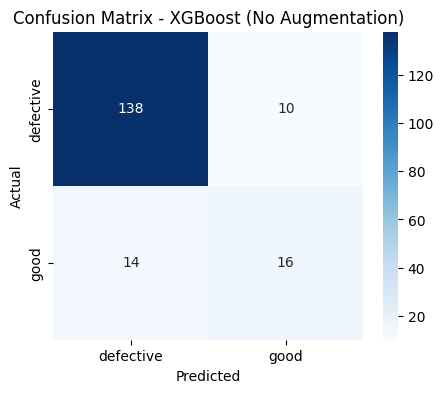


📘 Training summary saved successfully.


In [ ]:


import os, json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"   # expects defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models/XGBOOST/no agumentation"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE   = 512
LATENT_DIM = 256
EPOCHS_AE  = 30
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET + NO AUGMENTATION
# ============================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()      # keep in [0,1]
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Dataset loaded (NO augmentation): {len(dataset)} images → Train: {train_size}, Val: {val_size}")

# ============================================================
# 3️ AUTOENCODER MODEL
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=1024, img_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 8) * (img_size // 8)), nn.ReLU(),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, 2, 1, 1),
            nn.Sigmoid()  # outputs in [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

autoencoder = Autoencoder(LATENT_DIM, IMG_SIZE).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=3e-3)

# ============================================================
# 4️ TRAIN AUTOENCODER
# ============================================================
best_loss = float("inf")
print("\n=== Training Autoencoder (NO augmentation) ===")

for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        recon, _ = autoencoder(imgs)
        loss = criterion(recon, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS_AE}] - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE
        }, os.path.join(SAVE_DIR, "autoencoder_best_XGB2.pth"))
        print(f"✅ Saved best Autoencoder ({avg_loss:.4f})")

print("✅ Autoencoder training completed.")

# ============================================================
# 5️ FEATURE EXTRACTION
# ============================================================
def extract_features(model, loader):
    model.eval()
    feats, lbls = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            feats.append(z.cpu())
            lbls.append(labels)
    return torch.cat(feats).numpy(), torch.cat(lbls).numpy()

train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats, val_lbls     = extract_features(autoencoder, val_loader)
print(f"Train features: {train_feats.shape}, Val features: {val_feats.shape}")

# ============================================================
# 6️ XGBOOST CLASSIFIER
# ============================================================
print("\n=== Training XGBoost Classifier on Autoencoder Features ===")

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)
xgb.fit(train_feats, train_lbls)

# ============================================================
# 7️ EVALUATION
# ============================================================
val_preds = xgb.predict(val_feats)
acc = accuracy_score(val_lbls, val_preds)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(val_lbls, val_preds, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(val_lbls, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix - XGBoost (No Augmentation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ============================================================
# 8️ SAVE XGBOOST MODEL + SUMMARY
# ============================================================
xgb.save_model(os.path.join(SAVE_DIR, "xgboost_model_NOAUG2.json"))

summary = {
    "autoencoder_best_loss": float(best_loss),
    "xgboost_val_acc": float(acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "augmentation": "None (Baseline)",
    "model_type": "Autoencoder + XGBoost"
}
with open(os.path.join(SAVE_DIR, "training_summary_XGBoost_NOAUG.json"), "w") as f:
    json.dump(summary, f, indent=4)

print("\n📘 Training summary saved successfully.")


###  light agumentation

Running on cuda
Dataset loaded (Rotation ±5°): 888 images → Train: 710, Val: 178
Classes: ['defective', 'good']

=== Training Autoencoder (Rotation ±5°) ===
Epoch [1/30] - TrainLoss: 0.0324 | ValRecon: 0.0139
✅ Saved best Autoencoder (ValRecon 0.0139)
Epoch [2/30] - TrainLoss: 0.0113 | ValRecon: 0.0074
✅ Saved best Autoencoder (ValRecon 0.0074)
Epoch [3/30] - TrainLoss: 0.0067 | ValRecon: 0.0054
✅ Saved best Autoencoder (ValRecon 0.0054)
Epoch [4/30] - TrainLoss: 0.0054 | ValRecon: 0.0048
✅ Saved best Autoencoder (ValRecon 0.0048)
Epoch [5/30] - TrainLoss: 0.0046 | ValRecon: 0.0048
✅ Saved best Autoencoder (ValRecon 0.0048)
Epoch [6/30] - TrainLoss: 0.0040 | ValRecon: 0.0040
✅ Saved best Autoencoder (ValRecon 0.0040)
Epoch [7/30] - TrainLoss: 0.0036 | ValRecon: 0.0037
✅ Saved best Autoencoder (ValRecon 0.0037)
Epoch [8/30] - TrainLoss: 0.0033 | ValRecon: 0.0033
✅ Saved best Autoencoder (ValRecon 0.0033)
Epoch [9/30] - TrainLoss: 0.0032 | ValRecon: 0.0033
✅ Saved best Autoencoder (ValRe

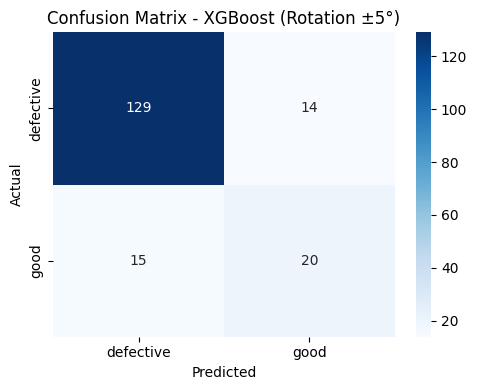


📘 Training summary saved successfully.


In [ ]:


import os, json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR  = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # subfolders: defective/, non_defective/
SAVE_DIR  = "/content/drive/MyDrive/From Roboflow/All views/models/XGBOOST/light agumentation"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE   = 512
LATENT_DIM = 256          # you can try 512/1024 if capacity seems low
EPOCHS_AE  = 30
PATIENCE   = 6            # early stopping
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

torch.backends.cudnn.benchmark = True

# ============================================================
# 2️ DATASET + LIGHT AUGMENTATION (Rotation Only, ±5°)
# ============================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=5),   # ✅ ±5° only
    transforms.ToTensor()                   # keep in [0,1] to match Sigmoid() output
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
train_len = int(0.8 * len(dataset))
val_len   = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset loaded (Rotation ±5°): {len(dataset)} images → Train: {train_len}, Val: {val_len}")
print(f"Classes: {dataset.classes}")

# ============================================================
# 3️ AUTOENCODER MODEL
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256, img_size=512):
        super().__init__()
        self.img_size = img_size
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 8) * (img_size // 8)), nn.ReLU(inplace=True),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3,   3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # outputs in [0,1] to match ToTensor()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

autoencoder = Autoencoder(LATENT_DIM, IMG_SIZE).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=3e-3)  # 🔺 slightly higher to avoid plateau

# ============================================================
# 4️ TRAIN AUTOENCODER (with early stopping on train loss)
# ============================================================
best_loss = float("inf")
pat_count = 0

def evaluate_recon_loss(model, loader):
    model.eval()
    loss_sum = 0.0
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(DEVICE)
            recon, _ = model(imgs)
            loss_sum += criterion(recon, imgs).item()
    return loss_sum / max(1, len(loader))

print("\n=== Training Autoencoder (Rotation ±5°) ===")
for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        recon, _ = autoencoder(imgs)
        loss = criterion(recon, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    val_recon = evaluate_recon_loss(autoencoder, val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS_AE}] - TrainLoss: {avg_loss:.4f} | ValRecon: {val_recon:.4f}")

    # Save best on validation reconstruction
    if val_recon < best_loss:
        best_loss = val_recon
        pat_count = 0
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE
        }, os.path.join(SAVE_DIR, "autoencoder_best_XGB_ROT.pth"))
        print(f"✅ Saved best Autoencoder (ValRecon {val_recon:.4f})")
    else:
        pat_count += 1
        if pat_count >= PATIENCE:
            print("⏹️ Early stopping (no val improvement).")
            break

print("✅ Autoencoder training completed.")

# ============================================================
# 5️ FEATURE EXTRACTION
# ============================================================
def extract_features(model, loader):
    model.eval()
    feats, lbls = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            feats.append(z.cpu())
            lbls.append(labels)
    return torch.cat(feats).numpy(), torch.cat(lbls).numpy()

train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats,   val_lbls   = extract_features(autoencoder, val_loader)
print(f"Train features: {train_feats.shape}, Val features: {val_feats.shape}")

# ============================================================
# 6️ XGBOOST CLASSIFIER
# ============================================================
print("\n=== Training XGBoost Classifier on Autoencoder Features ===")
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)
xgb.fit(train_feats, train_lbls)

# ============================================================
# 7️ EVALUATION
# ============================================================
val_preds = xgb.predict(val_feats)
acc = accuracy_score(val_lbls, val_preds)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(val_lbls, val_preds, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(val_lbls, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix - XGBoost (Rotation ±5°)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 8️ SAVE XGBOOST MODEL + SUMMARY
# ============================================================
xgb.save_model(os.path.join(SAVE_DIR, "xgboost_model_ROT.json"))

summary = {
    "autoencoder_best_val_recon": float(best_loss),
    "xgboost_val_acc": float(acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "augmentation": "Rotation Only (±5°)",
    "model_type": "Autoencoder + XGBoost",
    "classes": dataset.classes
}
with open(os.path.join(SAVE_DIR, "training_summary_XGBoost_ROT.json"), "w") as f:
    json.dump(summary, f, indent=4)

print("\n Training summary saved successfully.")


 ## Heavy agumentation

Running on cuda
Dataset loaded (HEAVY augmentation): 888 images → Train: 710, Val: 178
Classes: ['defective', 'good']

=== Training Autoencoder (HEAVY augmentation) ===
Epoch [1/30] - Train: 0.0515 | Val: 0.0364
✅ Saved best Autoencoder (Val 0.0364)
Epoch [2/30] - Train: 0.0310 | Val: 0.0233
✅ Saved best Autoencoder (Val 0.0233)
Epoch [3/30] - Train: 0.0217 | Val: 0.0179
✅ Saved best Autoencoder (Val 0.0179)
Epoch [4/30] - Train: 0.0173 | Val: 0.0142
✅ Saved best Autoencoder (Val 0.0142)
Epoch [5/30] - Train: 0.0145 | Val: 0.0141
✅ Saved best Autoencoder (Val 0.0141)
Epoch [6/30] - Train: 0.0131 | Val: 0.0114
✅ Saved best Autoencoder (Val 0.0114)
Epoch [7/30] - Train: 0.0118 | Val: 0.0106
✅ Saved best Autoencoder (Val 0.0106)
Epoch [8/30] - Train: 0.0115 | Val: 0.0108
Epoch [9/30] - Train: 0.0107 | Val: 0.0100
✅ Saved best Autoencoder (Val 0.0100)
Epoch [10/30] - Train: 0.0105 | Val: 0.0093
✅ Saved best Autoencoder (Val 0.0093)
Epoch [11/30] - Train: 0.0097 | Val: 0.0086
✅ Saved best A

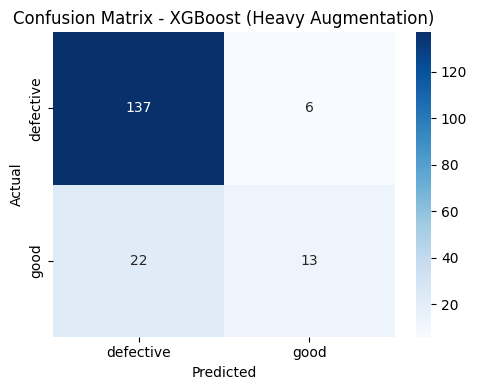


📘 Training summary saved successfully.


In [ ]:


import os, json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"   # folders: defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models/XGBOOST/Heavy agumentation"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE   = 512
LATENT_DIM = 256
EPOCHS_AE  = 30
PATIENCE   = 6          # early stopping for AE
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

torch.backends.cudnn.benchmark = True

# ============================================================
# 2️ DATASET + HEAVY AUGMENTATION (NO NORMALIZATION)
# ============================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=15),                        # ±15° rotation
    transforms.RandomHorizontalFlip(p=0.5),                       # 50% horizontal flip
    transforms.RandomVerticalFlip(p=0.3),                         # 30% vertical flip
    transforms.ColorJitter(brightness=0.3, contrast=0.3,
                           saturation=0.3, hue=0.05),             # lighting variation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1),
                            scale=(0.9, 1.1)),                    # shift + zoom
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),    # mild perspective distortion
    transforms.ToTensor()                                         # ⚠️ NO normalization (matches Sigmoid)
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
train_len = int(0.8 * len(dataset))
val_len   = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset loaded (HEAVY augmentation): {len(dataset)} images → Train: {train_len}, Val: {val_len}")
print(f"Classes: {dataset.classes}")

# ============================================================
# 3️ AUTOENCODER MODEL
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256, img_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 8) * (img_size // 8)), nn.ReLU(inplace=True),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # ✅ matches [0,1] range of ToTensor()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

autoencoder = Autoencoder(LATENT_DIM, IMG_SIZE).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=3e-3)  # slightly higher LR for stability

# ============================================================
# 4️ TRAIN AUTOENCODER (with early stopping)
# ============================================================
best_loss = float("inf")
patience = 0

def evaluate_loss(model, loader):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(DEVICE)
            recon, _ = model(imgs)
            loss_sum += criterion(recon, imgs).item()
    return loss_sum / len(loader)

print("\n=== Training Autoencoder (HEAVY augmentation) ===")
for epoch in range(EPOCHS_AE):
    autoencoder.train()
    total_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        recon, _ = autoencoder(imgs)
        loss = criterion(recon, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    val_loss = evaluate_loss(autoencoder, val_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS_AE}] - Train: {avg_loss:.4f} | Val: {val_loss:.4f}")

    # Early stopping + save best model
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        torch.save({
            "model_state_dict": autoencoder.state_dict(),
            "latent_dim": LATENT_DIM,
            "img_size": IMG_SIZE
        }, os.path.join(SAVE_DIR, "autoencoder_best_XGB_HEAVY.pth"))
        print(f"✅ Saved best Autoencoder (Val {val_loss:.4f})")
    else:
        patience += 1
        if patience >= PATIENCE:
            print("⏹️ Early stopping (no improvement).")
            break

print("✅ Autoencoder training completed.")

# ============================================================
# 5️ FEATURE EXTRACTION
# ============================================================
def extract_features(model, loader):
    model.eval()
    feats, lbls = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            _, z = model(imgs)
            feats.append(z.cpu())
            lbls.append(labels)
    return torch.cat(feats).numpy(), torch.cat(lbls).numpy()

train_feats, train_lbls = extract_features(autoencoder, train_loader)
val_feats,   val_lbls   = extract_features(autoencoder, val_loader)
print(f"Train features: {train_feats.shape}, Val features: {val_feats.shape}")

# ============================================================
# 6️ XGBOOST CLASSIFIER
# ============================================================
print("\n=== Training XGBoost Classifier on Autoencoder Features ===")

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)
xgb.fit(train_feats, train_lbls)

# ============================================================
# 7️ EVALUATION
# ============================================================
val_preds = xgb.predict(val_feats)
acc = accuracy_score(val_lbls, val_preds)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(val_lbls, val_preds, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(val_lbls, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix - XGBoost (Heavy Augmentation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 8️ SAVE XGBOOST MODEL + SUMMARY
# ============================================================
xgb.save_model(os.path.join(SAVE_DIR, "xgboost_model_HEAVY.json"))

summary = {
    "autoencoder_best_val_loss": float(best_loss),
    "xgboost_val_acc": float(acc),
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "epochs_ae": EPOCHS_AE,
    "augmentation": "Heavy (Rotation ±15°, Flip, ColorJitter, Affine, Perspective)",
    "model_type": "Autoencoder + XGBoost",
    "classes": dataset.classes
}
with open(os.path.join(SAVE_DIR, "training_summary_XGBoost_HEAVY.json"), "w") as f:
    json.dump(summary, f, indent=4)

print("\n Training summary saved successfully.")


# CNN Backbone Feature Extraction (Training)

## RESNET

### No agumenation

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (NO augmentation)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------

Classes: ['defective', 'good']
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]



=== Training ResNet18 Classifier ===
Epoch [1/30] - TrainLoss: 0.4586, ValLoss: 0.4912, ValAcc: 83.15%
✅ Saved best ResNet18 (Val Acc: 83.15%)
Epoch [2/30] - TrainLoss: 0.3614, ValLoss: 0.3918, ValAcc: 85.96%
✅ Saved best ResNet18 (Val Acc: 85.96%)
Epoch [3/30] - TrainLoss: 0.2263, ValLoss: 0.3914, ValAcc: 84.83%
Epoch [4/30] - TrainLoss: 0.2422, ValLoss: 0.3991, ValAcc: 82.58%
Epoch [5/30] - TrainLoss: 0.1782, ValLoss: 0.3752, ValAcc: 84.27%
Epoch [6/30] - TrainLoss: 0.0870, ValLoss: 0.4711, ValAcc: 84.83%
Epoch [7/30] - TrainLoss: 0.0614, ValLoss: 0.7321, ValAcc: 77.53%
Epoch [8/30] - TrainLoss: 0.0806, ValLoss: 0.4170, ValAcc: 83.15%
Epoch [9/30] - TrainLoss: 0.0315, ValLoss: 0.5097, ValAcc: 87.64%
✅ Saved best ResNet18 (Val Acc: 87.64%)
Epoch [10/30] - TrainLoss: 0.0277, ValLoss: 0.4931, ValAcc: 84.83%
Epoch [11/30] - TrainLoss: 0.0144, ValLoss: 0.5659, ValAcc: 84.27%
Epoch [12/30] - TrainLoss: 0.0143, ValLoss: 0.4591, ValAcc: 87.64%
Epoch [13/30] - TrainLoss: 0.0252, ValLoss: 0.4

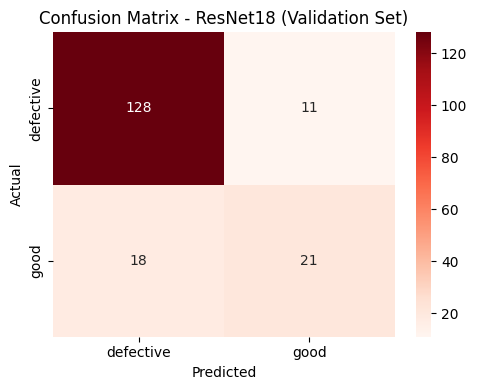

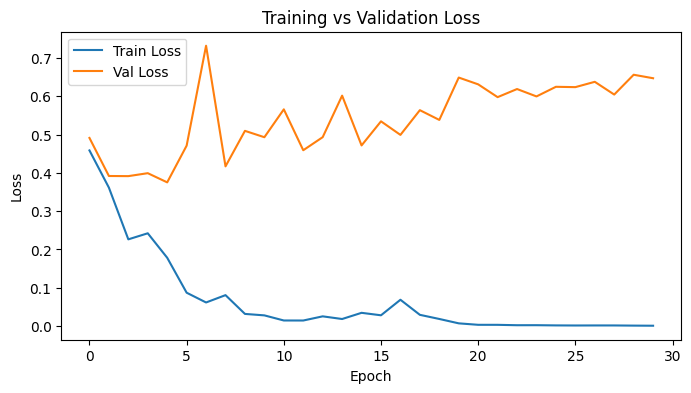

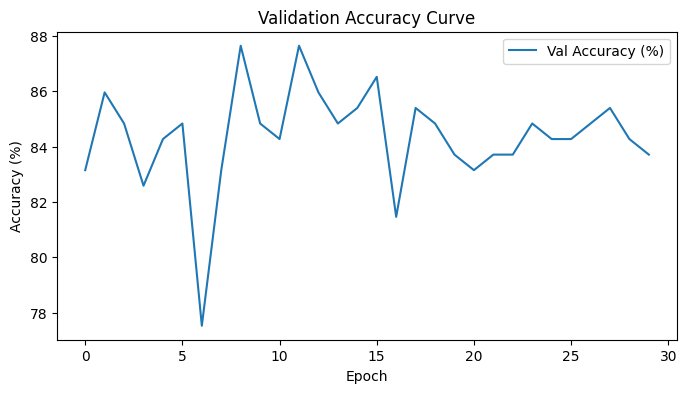

📘 Training summary saved to /content/drive/MyDrive/From Roboflow/All views/models/no agumentation_direct/training_summary_resnet18_direct.json

=== Final Evaluation on Unseen Test Set ===
--- THIS IS THE REPORT FOR YOUR THESIS ---

=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

   defective       0.86      0.94      0.90       139
        good       0.69      0.46      0.55        39

    accuracy                           0.84       178
   macro avg       0.78      0.70      0.73       178
weighted avg       0.82      0.84      0.82       178


=== CONFUSION MATRIX (Test Set) ===
[[131   8]
 [ 21  18]]

Format: (row = True Label, col = Predicted Label)
          [Pred defective] [Pred good]
[True defective]         131              8
[True good]          21             18


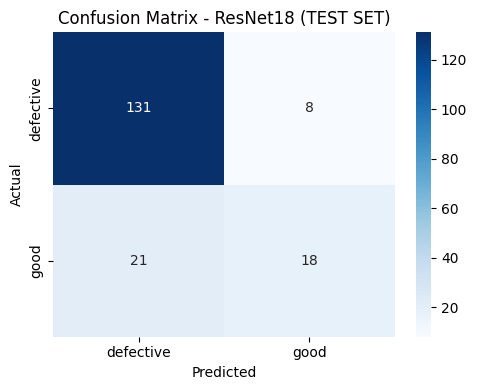


✅ Evaluation complete.


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/no agumentation_direct"

os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
EPOCHS = 30
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET AND NORMALIZATION [FIXED]
# ============================================================

# [FIX 1: Data Leakage Structure]
# Define separate transforms for training and validation/testing
# (Even if they are identical, this is the correct structure)
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
train_data = Subset(train_dataset, train_indices)
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices) # <--- NEW TEST SET

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (NO augmentation)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")
print(f"Classes: {class_names}")


# ============================================================
# 3️ MODEL: RESNET-18 (Pretrained Backbone)
# ============================================================
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================================================
# 4️ TRAINING LOOP
# ============================================================
best_acc = 0.0
train_losses, val_losses, val_accuracies = [], [], []
# Define path for best model
best_path = os.path.join(SAVE_DIR, f"resnet18_best_direct_img{IMG_SIZE}.pth")

print("\n=== Training ResNet18 Classifier ===")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - TrainLoss: {avg_train_loss:.4f}, ValLoss: {avg_val_loss:.4f}, ValAcc: {acc:.2f}%")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "epochs": epoch+1,
            "val_acc": acc
        }, best_path)
        print(f"✅ Saved best ResNet18 (Val Acc: {acc:.2f}%)")

print(f"\n✅ Training complete. Best Val Acc: {best_acc:.2f}%")

# ============================================================
# 5️ EVALUATION + CONFUSION MATRIX (On Validation Set)
# ============================================================
# This section is fine for checking validation data, but it is NOT your final result.
print("\n--- Validation Set Report ---")
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

cm_val = confusion_matrix(all_labels, all_preds)
print("\nClassification Report (Validation):")
print(classification_report(all_labels, all_preds, target_names=class_names))

plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet18 (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 6️ PLOT LOSS / ACCURACY CURVES
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_accuracies, label="Val Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.show()

# ============================================================
# 7️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_resnet18_direct.json")
summary = {
    "best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "epochs": EPOCHS,
    "classes": class_names,
    "augmentation": "None (Baseline)",
    "data_split": {
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f" Training summary saved to {summary_path}")


# ============================================================
# 8️ FINAL EVALUATION ON TEST SET [NEW & FIXED]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")
print("--- THIS IS THE REPORT FOR YOUR THESIS ---")

# 1. Load the BEST saved model
# First, re-define the model architecture
final_model = models.resnet18(weights=None) # Do not use pretrained weights
final_model.fc = nn.Linear(final_model.fc.in_features, NUM_CLASSES)

# Load the saved state dictionary
checkpoint = torch.load(best_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model = final_model.to(DEVICE)
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for imgs, labels in test_loader: # <-- Use test_loader
        imgs = imgs.to(DEVICE)

        preds = final_model(imgs)
        all_preds_test.append(preds.argmax(1).cpu())
        all_labels_test.append(labels.cpu())

all_preds_test = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm_test = confusion_matrix(all_labels_test, all_preds_test)
print(cm_test)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm_test[0,0]:>11} {cm_test[0,1]:>14}")
print(f"[True {class_names[1]}] {cm_test[1,0]:>11} {cm_test[1,1]:>14}")

# 5. Plot the TEST confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet18 (TEST SET)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete.")

### light agumenation

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (light rotation ±10°)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------

Classes: ['defective', 'good']

=== Training ResNet18 (Light Rotation ±10°) ===
Epoch [1/15] - TrainLoss: 0.4419, ValLoss: 0.5106, ValAcc: 82.58%
✅ Saved best ResNet18 (Val Acc: 82.58%)
Epoch [2/15] - TrainLoss: 0.3756, ValLoss: 0.3629, ValAcc: 85.39%
✅ Saved best ResNet18 (Val Acc: 85.39%)
Epoch [3/15] - TrainLoss: 0.3469, ValLoss: 0.3845, ValAcc: 85.96%
✅ Saved best ResNet18 (Val Acc: 85.96%)
Epoch [4/15] - TrainLoss: 0.3270, ValLoss: 0.3530, ValAcc: 87.08%
✅ Saved best ResNet18 (Val Acc: 87.08%)
Epoch [5/15] - TrainLoss: 0.3000, ValLoss: 0.4004, ValAcc: 83.71%
Epoch [6/15] - TrainLoss: 0.2872, ValLoss: 0.5038, ValAcc: 82.02%
Epoch [7/15] - TrainLoss: 0.2462, ValLoss: 0.5862, ValAcc: 83.15%
Epoch [8/15] - TrainLoss: 0.2273, ValLoss: 0.3481, ValAcc: 85.9

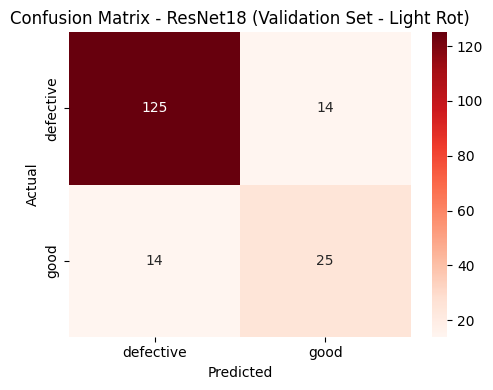

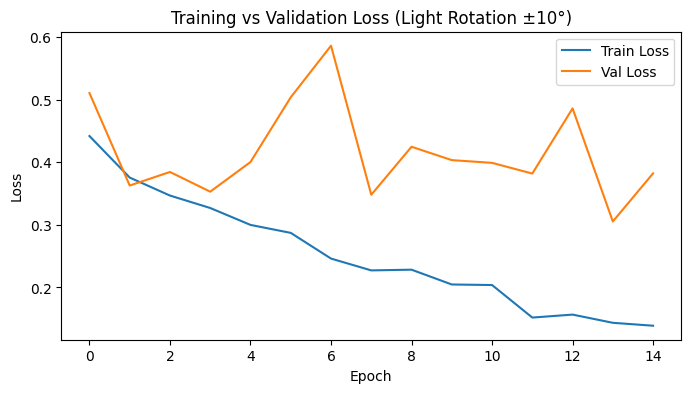

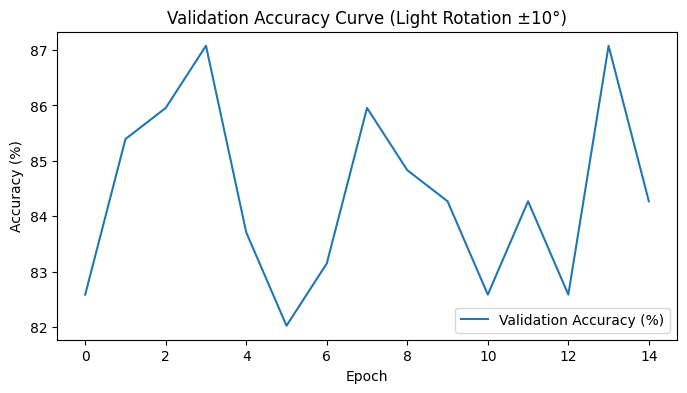

📘 Training summary saved to /content/drive/MyDrive/From Roboflow/All views/models0/RESNET/light_rotation_direct/training_summary_light_rotation.json

=== Final Evaluation on Unseen Test Set ===
--- THIS IS THE REPORT FOR YOUR THESIS ---

=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

   defective       0.89      0.96      0.92       139
        good       0.79      0.59      0.68        39

    accuracy                           0.88       178
   macro avg       0.84      0.77      0.80       178
weighted avg       0.87      0.88      0.87       178


=== CONFUSION MATRIX (Test Set) ===
[[133   6]
 [ 16  23]]

Format: (row = True Label, col = Predicted Label)
          [Pred defective] [Pred good]
[True defective]         133              6
[True good]          16             23


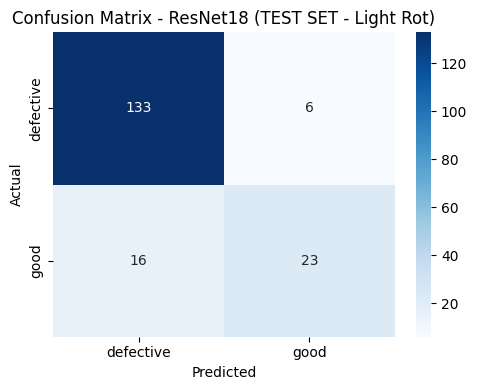


✅ Evaluation complete.


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/RESNET/light_rotation_direct"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
EPOCHS = 15
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET + LIGHT ROTATION AUGMENTATION [FIXED]
# ============================================================

# [FIX 1: Data Leakage]
# Create two separate transforms.
# Augmentation should ONLY be applied to the training set.
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=10),  # light ±10° rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
# Train data uses the AUGMENTED transform
train_data = Subset(train_dataset, train_indices)
# Val and Test data use the CLEAN (non-augmented) transform
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices) # <--- NEW TEST SET

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (light rotation ±10°)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")
print(f"Classes: {class_names}")

# ============================================================
# 3️ MODEL: RESNET-18 (Pretrained on ImageNet)
# ============================================================
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================================================
# 4️ TRAINING LOOP
# ============================================================
train_losses, val_losses, val_accuracies = [], [], []
best_acc = 0.0
# Define path for best model
best_path = os.path.join(SAVE_DIR, f"resnet18_best_light_rotation_img{IMG_SIZE}.pth")

print("\n=== Training ResNet18 (Light Rotation ±10°) ===")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - TrainLoss: {avg_train_loss:.4f}, ValLoss: {avg_val_loss:.4f}, ValAcc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "epochs": epoch+1,
            "val_acc": acc
        }, best_path)
        print(f"✅ Saved best ResNet18 (Val Acc: {acc:.2f}%)")

print(f"\n✅ Training complete. Best Validation Accuracy: {best_acc:.2f}%")

# ============================================================
# 5️ EVALUATION + CONFUSION MATRIX (On Validation Set)
# ============================================================
# This section is fine for checking validation data, but it is NOT your final result.
print("\n--- Validation Set Report ---")
model.eval()
all_preds_val, all_labels_val = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(1).cpu()
        all_preds_val.extend(preds.numpy())
        all_labels_val.extend(labels.numpy())

print("\nClassification Report (Validation):")
print(classification_report(all_labels_val, all_preds_val, target_names=class_names))

cm_val = confusion_matrix(all_labels_val, all_preds_val)
plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet18 (Validation Set - Light Rot)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 6️ PLOT LOSS / ACCURACY CURVES
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Light Rotation ±10°)")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_accuracies, label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve (Light Rotation ±10°)")
plt.legend()
plt.show()

# ============================================================
# 7️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_light_rotation.json")
summary = {
    "best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "epochs": EPOCHS,
    "augmentation": "Light Rotation ±10°",
    "classes": class_names,
    "data_split": { # Added
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f" Training summary saved to {summary_path}")

# ============================================================
# 8️ FINAL EVALUATION ON TEST SET [NEW & FIXED]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")
print("--- THIS IS THE REPORT FOR YOUR THESIS ---")

# 1. Load the BEST saved model
# First, re-define the model architecture
final_model = models.resnet18(weights=None) # Do not use pretrained weights
final_model.fc = nn.Linear(final_model.fc.in_features, NUM_CLASSES)

# Load the saved state dictionary
checkpoint = torch.load(best_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model = final_model.to(DEVICE)
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for imgs, labels in test_loader: # <-- Use test_loader
        imgs = imgs.to(DEVICE)

        preds = final_model(imgs)
        all_preds_test.append(preds.argmax(1).cpu())
        all_labels_test.append(labels.cpu())

all_preds_test = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm_test = confusion_matrix(all_labels_test, all_preds_test)
print(cm_test)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm_test[0,0]:>11} {cm_test[0,1]:>14}")
print(f"[True {class_names[1]}] {cm_test[1,0]:>11} {cm_test[1,1]:>14}")

# 5. Plot the TEST confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet18 (TEST SET - Light Rot)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete.")

### Heavy agumentation

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (HEAVY augmentation)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------

Classes: ['defective', 'good']

=== Training ResNet18 (HEAVY Augmentation) ===
Epoch [1/30] - TrainLoss: 0.4666, ValLoss: 0.4620, ValAcc: 81.46%
✅ Saved best ResNet18 (Val Acc: 81.46%)
Epoch [2/30] - TrainLoss: 0.4294, ValLoss: 0.3996, ValAcc: 82.02%
✅ Saved best ResNet18 (Val Acc: 82.02%)
Epoch [3/30] - TrainLoss: 0.3498, ValLoss: 0.4557, ValAcc: 81.46%
Epoch [4/30] - TrainLoss: 0.3410, ValLoss: 0.4005, ValAcc: 84.27%
✅ Saved best ResNet18 (Val Acc: 84.27%)
Epoch [5/30] - TrainLoss: 0.3456, ValLoss: 0.3860, ValAcc: 82.58%
Epoch [6/30] - TrainLoss: 0.3278, ValLoss: 0.4008, ValAcc: 83.71%
Epoch [7/30] - TrainLoss: 0.3270, ValLoss: 0.3910, ValAcc: 84.27%
Epoch [8/30] - TrainLoss: 0.3184, ValLoss: 0.3381, ValAcc: 85.96%
✅ Saved best ResNet18 (Val Acc: 85.96%)

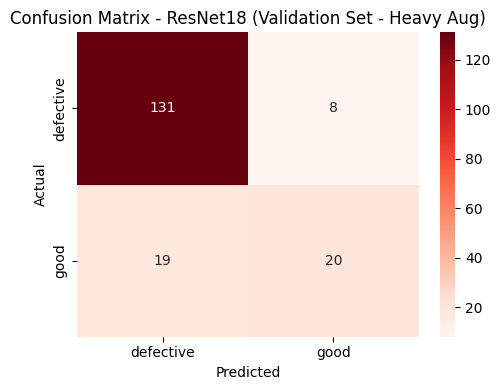

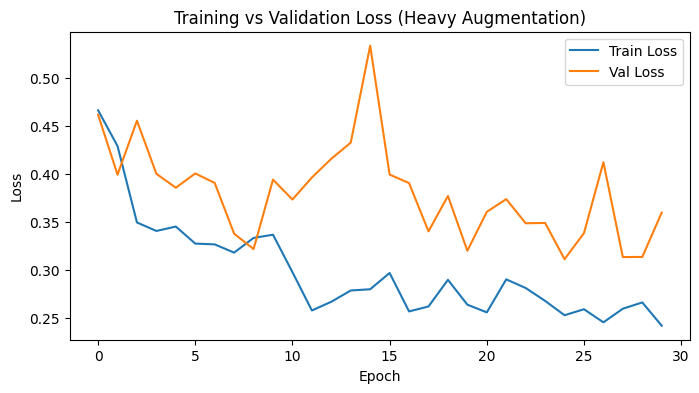

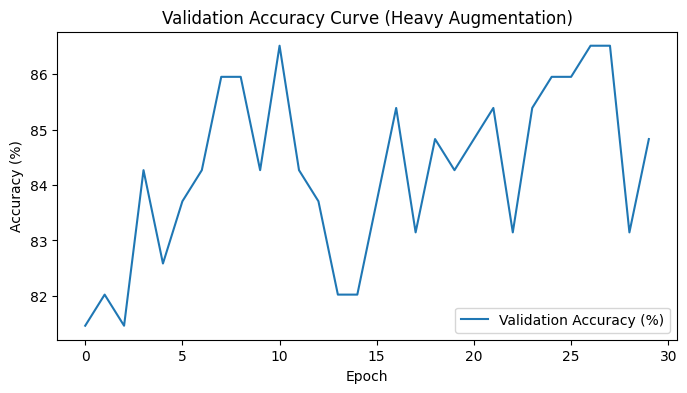

📘 Training summary saved to /content/drive/MyDrive/From Roboflow/All views/models/RESNET/heavy_augmentation_direct/training_summary_HEAVY_DIRECT.json

=== Final Evaluation on Unseen Test Set ===
--- THIS IS THE REPORT FOR YOUR THESIS ---

=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

   defective       0.87      0.99      0.92       139
        good       0.90      0.46      0.61        39

    accuracy                           0.87       178
   macro avg       0.88      0.72      0.77       178
weighted avg       0.87      0.87      0.85       178


=== CONFUSION MATRIX (Test Set) ===
[[137   2]
 [ 21  18]]

Format: (row = True Label, col = Predicted Label)
          [Pred defective] [Pred good]
[True defective]         137              2
[True good]          21             18


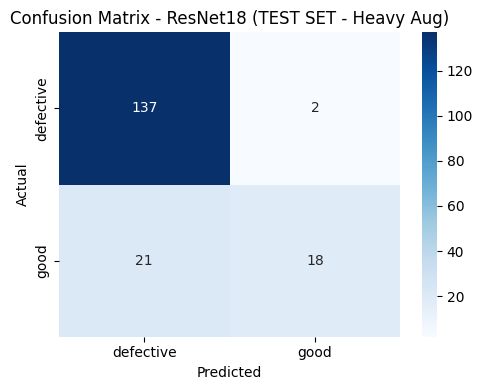


✅ Evaluation complete.


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models/RESNET/heavy_augmentation_direct"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
EPOCHS = 30
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ HEAVY DATA AUGMENTATION + NORMALIZATION [FIXED]
# ============================================================

# [FIX 1: Data Leakage]
# Create two separate transforms.
# Augmentation should ONLY be applied to the training set.
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
# Train data uses the AUGMENTED transform
train_data = Subset(train_dataset, train_indices)
# Val and Test data use the CLEAN (non-augmented) transform
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices) # <--- NEW TEST SET

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (HEAVY augmentation)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")
print(f"Classes: {class_names}")

# ============================================================
# 3️ MODEL: RESNET-18 (Pretrained Backbone)
# ============================================================
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================================================
# 4️ TRAINING LOOP
# ============================================================
train_losses, val_losses, val_accuracies = [], [], []
best_acc = 0.0
# Define path for best model
best_path = os.path.join(SAVE_DIR, f"resnet18_best_HEAVY_img{IMG_SIZE}.pth")

print("\n=== Training ResNet18 (HEAVY Augmentation) ===")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - TrainLoss: {avg_train_loss:.4f}, ValLoss: {avg_val_loss:.4f}, ValAcc: {acc:.2f}%")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "epochs": epoch+1,
            "val_acc": acc
        }, best_path)
        print(f"✅ Saved best ResNet18 (Val Acc: {acc:.2f}%)")

print(f"\n✅ Training complete. Best Validation Accuracy: {best_acc:.2f}%")

# ============================================================
# 5️ EVALUATION + CONFUSION MATRIX (On Validation Set)
# ============================================================
# This section is fine for checking validation data, but it is NOT your final result.
print("\n--- Validation Set Report ---")
model.eval() # Use the last state of the model, not necessarily the best one for this quick check
all_preds_val, all_labels_val = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(1).cpu()
        all_preds_val.extend(preds.numpy())
        all_labels_val.extend(labels.numpy())

print("\nClassification Report (Validation):")
print(classification_report(all_labels_val, all_preds_val, target_names=class_names))

cm_val = confusion_matrix(all_labels_val, all_preds_val)
plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet18 (Validation Set - Heavy Aug)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 6️ PLOT LOSS / ACCURACY CURVES
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Heavy Augmentation)")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_accuracies, label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve (Heavy Augmentation)")
plt.legend()
plt.show()

# ============================================================
# 7️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_HEAVY_DIRECT.json")
summary = {
    "best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "epochs": EPOCHS,
    "augmentation": "Heavy (Rotation ±15°, Flip, ColorJitter, Affine, Perspective)",
    "classes": class_names,
    "data_split": { # Added
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f" Training summary saved to {summary_path}")


# ============================================================
# 8️ FINAL EVALUATION ON TEST SET [NEW & FIXED]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")
print("--- THIS IS THE REPORT FOR YOUR THESIS ---")

# 1. Load the BEST saved model
# First, re-define the model architecture
final_model = models.resnet18(weights=None) # Do not use pretrained weights
final_model.fc = nn.Linear(final_model.fc.in_features, NUM_CLASSES)

# Load the saved state dictionary from the best checkpoint
checkpoint = torch.load(best_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model = final_model.to(DEVICE)
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for imgs, labels in test_loader: # <-- Use test_loader
        imgs = imgs.to(DEVICE)

        preds = final_model(imgs)
        all_preds_test.append(preds.argmax(1).cpu())
        all_labels_test.append(labels.cpu())

all_preds_test = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm_test = confusion_matrix(all_labels_test, all_preds_test)
print(cm_test)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm_test[0,0]:>11} {cm_test[0,1]:>14}")
print(f"[True {class_names[1]}] {cm_test[1,0]:>11} {cm_test[1,1]:>14}")

# 5. Plot the TEST confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet18 (TEST SET - Heavy Aug)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete.")

## MobileNETV

### No agumenation

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (NO augmentation)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------

Classes: ['defective', 'good']
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 144MB/s]



=== Training MobileNet V2 (No Augmentation) ===
Epoch [1/30] - TrainLoss: 0.5204, ValLoss: 0.4571, ValAcc: 81.46%
✅ Saved best MobileNet V2 (Val Acc: 81.46%)
Epoch [2/30] - TrainLoss: 0.3948, ValLoss: 0.3998, ValAcc: 82.02%
✅ Saved best MobileNet V2 (Val Acc: 82.02%)
Epoch [3/30] - TrainLoss: 0.2907, ValLoss: 0.4467, ValAcc: 80.90%
Epoch [4/30] - TrainLoss: 0.1745, ValLoss: 0.5236, ValAcc: 81.46%
Epoch [5/30] - TrainLoss: 0.1074, ValLoss: 0.5535, ValAcc: 83.15%
✅ Saved best MobileNet V2 (Val Acc: 83.15%)
Epoch [6/30] - TrainLoss: 0.0515, ValLoss: 0.5047, ValAcc: 80.34%
Epoch [7/30] - TrainLoss: 0.0927, ValLoss: 0.5534, ValAcc: 79.78%
Epoch [8/30] - TrainLoss: 0.0462, ValLoss: 0.5908, ValAcc: 80.90%
Epoch [9/30] - TrainLoss: 0.0145, ValLoss: 0.6503, ValAcc: 79.78%
Epoch [10/30] - TrainLoss: 0.0094, ValLoss: 0.7001, ValAcc: 79.78%
Epoch [11/30] - TrainLoss: 0.0091, ValLoss: 0.8113, ValAcc: 81.46%
Epoch [12/30] - TrainLoss: 0.0160, ValLoss: 0.8661, ValAcc: 72.47%
Epoch [13/30] - TrainLos

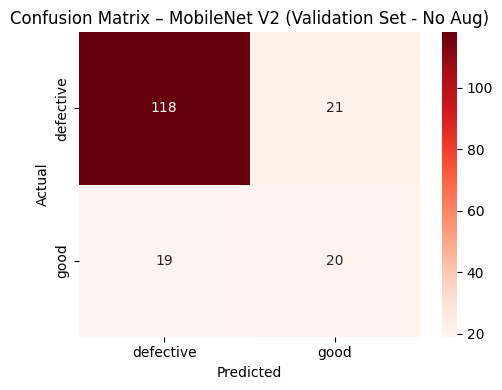

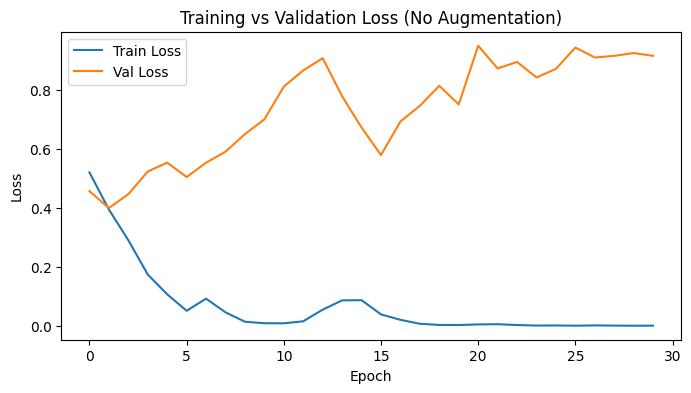

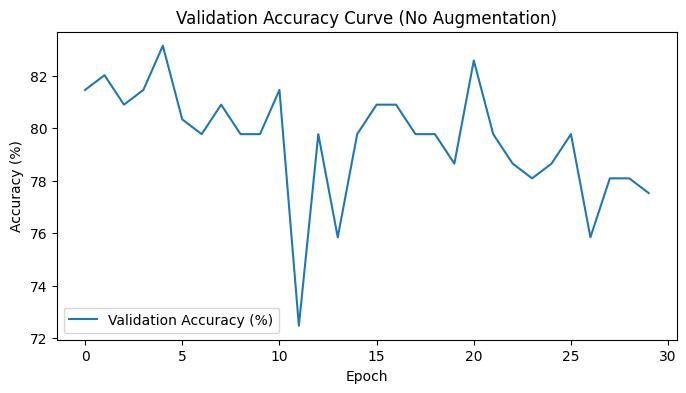

📘 Training summary saved to /content/drive/MyDrive/From Roboflow/All views/models0/MOBILENET/no_aug_direct/training_summary_MobileNet_NOAUG_DIRECT.json

=== Final Evaluation on Unseen Test Set ===
--- THIS IS THE REPORT FOR YOUR THESIS ---

=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

   defective       0.88      0.95      0.91       139
        good       0.75      0.54      0.63        39

    accuracy                           0.86       178
   macro avg       0.81      0.74      0.77       178
weighted avg       0.85      0.86      0.85       178


=== CONFUSION MATRIX (Test Set) ===
[[132   7]
 [ 18  21]]

Format: (row = True Label, col = Predicted Label)
          [Pred defective] [Pred good]
[True defective]         132              7
[True good]          18             21


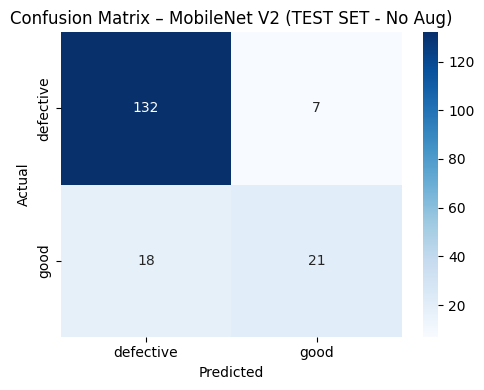


✅ Evaluation complete.


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/MOBILENET/no_aug_direct"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
EPOCHS = 30
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET AND NORMALIZATION (NO AUGMENTATION) [FIXED]
# ============================================================

# [FIX 1: Data Leakage Structure]
# Define separate transforms for training and validation/testing
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
train_data = Subset(train_dataset, train_indices)
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices) # <--- NEW TEST SET

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (NO augmentation)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")
print(f"Classes: {class_names}")


# ============================================================
# 3️ MODEL: MOBILENET V2 (PRETRAINED)
# ============================================================
model = models.mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.last_channel, NUM_CLASSES)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================================================
# 4️ TRAINING LOOP
# ============================================================
train_losses, val_losses, val_accuracies = [], [], []
best_acc = 0.0
# Define path for best model
best_path = os.path.join(SAVE_DIR, f"mobilenetv2_best_NOAUG_img{IMG_SIZE}.pth")

print("\n=== Training MobileNet V2 (No Augmentation) ===")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
           imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
           outputs = model(imgs)
           val_loss += criterion(outputs, labels).item()
           preds = outputs.argmax(1)
           correct += (preds == labels).sum().item()
           total += labels.size(0)
    val_loss /= len(val_loader)
    acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - TrainLoss: {train_loss:.4f}, ValLoss: {val_loss:.4f}, ValAcc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save({
           "model_state_dict": model.state_dict(),
           "epochs": epoch+1,
           "val_acc": acc
        }, best_path)
        print(f"✅ Saved best MobileNet V2 (Val Acc: {acc:.2f}%)")

print(f"\n✅ Training complete. Best Validation Accuracy: {best_acc:.2f}%")

# ============================================================
# 5️ EVALUATION + CONFUSION MATRIX (On Validation Set)
# ============================================================
# This section is fine for checking validation data, but it is NOT your final result.
print("\n--- Validation Set Report ---")
model.eval() # Use the last state of the model for this quick check
all_preds_val, all_labels_val = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(1).cpu()
        all_preds_val.extend(preds.numpy())
        all_labels_val.extend(labels.numpy())

print("\nClassification Report (Validation):")
print(classification_report(all_labels_val, all_preds_val, target_names=class_names))

cm_val = confusion_matrix(all_labels_val, all_preds_val)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Reds",
    xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix – MobileNet V2 (Validation Set - No Aug)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 6️ PLOT LOSS / ACCURACY CURVES
# ============================================================
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (No Augmentation)")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(val_accuracies, label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve (No Augmentation)")
plt.legend()
plt.show()

# ============================================================
# 7️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_MobileNet_NOAUG_DIRECT.json")
summary = {
    "best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "epochs": EPOCHS,
    "augmentation": "None (Baseline)",
    "classes": class_names,
    "data_split": { # Added
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f" Training summary saved to {summary_path}")


# ============================================================
# 8️ FINAL EVALUATION ON TEST SET [NEW & FIXED]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")
print("--- THIS IS THE REPORT FOR YOUR THESIS ---")

# 1. Load the BEST saved model
# First, re-define the model architecture
final_model = models.mobilenet_v2(weights=None) # Do not use pretrained weights
final_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.last_channel, NUM_CLASSES)
)

# Load the saved state dictionary from the best checkpoint
checkpoint = torch.load(best_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model = final_model.to(DEVICE)
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for imgs, labels in test_loader: # <-- Use test_loader
        imgs = imgs.to(DEVICE)

        preds = final_model(imgs)
        all_preds_test.append(preds.argmax(1).cpu())
        all_labels_test.append(labels.cpu())

all_preds_test = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm_test = confusion_matrix(all_labels_test, all_preds_test)
print(cm_test)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm_test[0,0]:>11} {cm_test[0,1]:>14}")
print(f"[True {class_names[1]}] {cm_test[1,0]:>11} {cm_test[1,1]:>14}")

# 5. Plot the TEST confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix – MobileNet V2 (TEST SET - No Aug)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete.")

### light agumenation

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (Rotation-Only ±5°)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------

Classes: ['defective', 'good']

=== Training MobileNet V2 (Rotation-Only ±5°) ===
Epoch [1/30] - TrainLoss: 0.4586, ValLoss: 0.4875, ValAcc: 81.46%
✅ Saved best MobileNet V2 (Val Acc: 81.46%)
Epoch [2/30] - TrainLoss: 0.4146, ValLoss: 0.4037, ValAcc: 82.02%
✅ Saved best MobileNet V2 (Val Acc: 82.02%)
Epoch [3/30] - TrainLoss: 0.3706, ValLoss: 0.3846, ValAcc: 81.46%
Epoch [4/30] - TrainLoss: 0.2968, ValLoss: 0.4391, ValAcc: 85.39%
✅ Saved best MobileNet V2 (Val Acc: 85.39%)
Epoch [5/30] - TrainLoss: 0.3107, ValLoss: 0.4406, ValAcc: 83.15%
Epoch [6/30] - TrainLoss: 0.2495, ValLoss: 0.3516, ValAcc: 84.83%
Epoch [7/30] - TrainLoss: 0.2260, ValLoss: 0.4698, ValAcc: 83.15%
Epoch [8/30] - TrainLoss: 0.2045, ValLoss: 0.4544, ValAcc: 84.27%
Epoch [9/30] - TrainLoss:

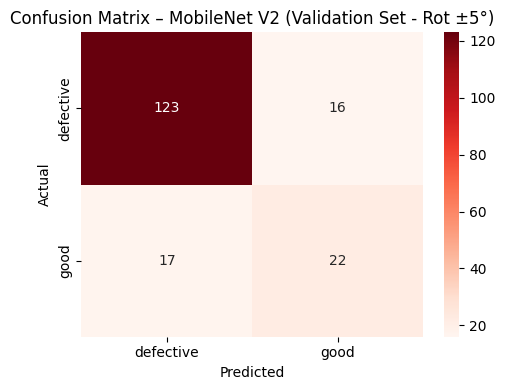

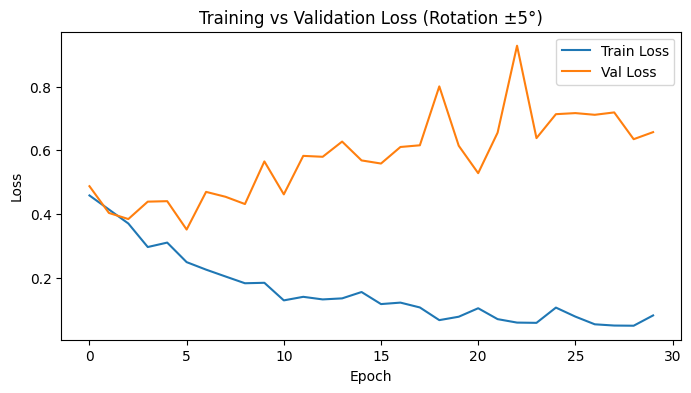

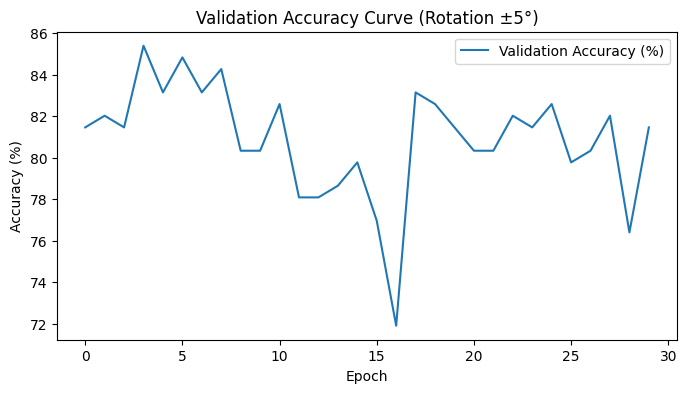

📘 Training summary saved to /content/drive/MyDrive/From Roboflow/All views/models/MOBILENET/light_rotation_direct/training_summary_MobileNet_ROT_DIRECT.json

=== Final Evaluation on Unseen Test Set ===
--- THIS IS THE REPORT FOR YOUR THESIS ---

=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

   defective       0.88      0.95      0.91       139
        good       0.75      0.54      0.63        39

    accuracy                           0.86       178
   macro avg       0.81      0.74      0.77       178
weighted avg       0.85      0.86      0.85       178


=== CONFUSION MATRIX (Test Set) ===
[[132   7]
 [ 18  21]]

Format: (row = True Label, col = Predicted Label)
          [Pred defective] [Pred good]
[True defective]         132              7
[True good]          18             21


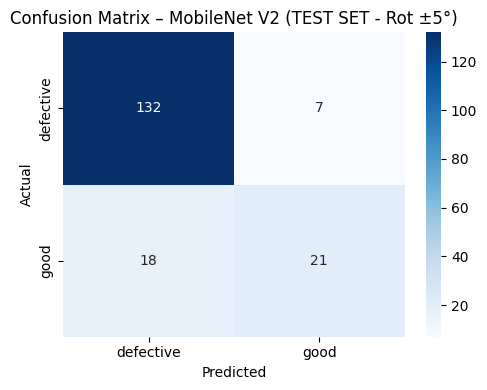


✅ Evaluation complete.


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Imports for stratified splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models/MOBILENET/light_rotation_direct"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
EPOCHS = 30
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET + ROTATION-ONLY AUGMENTATION (±5°) [FIXED]
# ============================================================

# [FIX 1: Data Leakage]
# Create two separate transforms.
# Augmentation should ONLY be applied to the training set.
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=5),  # 🔹 small ±5° rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
# Train data uses the AUGMENTED transform
train_data = Subset(train_dataset, train_indices)
# Val and Test data use the CLEAN (non-augmented) transform
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices) # <--- NEW TEST SET

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (Rotation-Only ±5°)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")
print(f"Classes: {class_names}")


# ============================================================
# 3️ MODEL: MOBILENET V2 (PRETRAINED)
# ============================================================
model = models.mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.last_channel, NUM_CLASSES)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================================================
# 4️ TRAINING LOOP
# ============================================================
train_losses, val_losses, val_accuracies = [], [], []
best_acc = 0.0
# Define path for best model
best_path = os.path.join(SAVE_DIR, f"mobilenetv2_best_ROT_img{IMG_SIZE}.pth")

print("\n=== Training MobileNet V2 (Rotation-Only ±5°) ===")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - TrainLoss: {train_loss:.4f}, ValLoss: {val_loss:.4f}, ValAcc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "epochs": epoch+1,
            "val_acc": acc
        }, best_path)
        print(f"✅ Saved best MobileNet V2 (Val Acc: {acc:.2f}%)")

print(f"\n✅ Training complete. Best Validation Accuracy: {best_acc:.2f}%")

# ============================================================
# 5️ EVALUATION + CONFUSION MATRIX (On Validation Set)
# ============================================================
# This section is fine for checking validation data, but it is NOT your final result.
print("\n--- Validation Set Report ---")
model.eval() # Use the last state of the model for this quick check
all_preds_val, all_labels_val = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(1).cpu()
        all_preds_val.extend(preds.numpy())
        all_labels_val.extend(labels.numpy())

print("\nClassification Report (Validation):")
print(classification_report(all_labels_val, all_preds_val, target_names=class_names))

cm_val = confusion_matrix(all_labels_val, all_preds_val)
plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix – MobileNet V2 (Validation Set - Rot ±5°)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 6️ PLOT LOSS / ACCURACY CURVES
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Rotation ±5°)")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_accuracies, label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve (Rotation ±5°)")
plt.legend()
plt.show()

# ============================================================
# 7️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_MobileNet_ROT_DIRECT.json")
summary = {
    "best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "epochs": EPOCHS,
    "augmentation": "Rotation Only (±5°)",
    "classes": class_names,
    "data_split": { # Added
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f" Training summary saved to {summary_path}")

# ============================================================
# 8️ FINAL EVALUATION ON TEST SET [NEW & FIXED]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")
print("--- THIS IS THE REPORT FOR YOUR THESIS ---")

# 1. Load the BEST saved model
# First, re-define the model architecture
final_model = models.mobilenet_v2(weights=None) # Do not use pretrained weights
final_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(final_model.last_channel, NUM_CLASSES) # Use final_model here
)

# Load the saved state dictionary from the best checkpoint
checkpoint = torch.load(best_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model = final_model.to(DEVICE)
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for imgs, labels in test_loader: # <-- Use test_loader
        imgs = imgs.to(DEVICE)

        preds = final_model(imgs)
        all_preds_test.append(preds.argmax(1).cpu())
        all_labels_test.append(labels.cpu())

all_preds_test = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm_test = confusion_matrix(all_labels_test, all_preds_test)
print(cm_test)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm_test[0,0]:>11} {cm_test[0,1]:>14}")
print(f"[True {class_names[1]}] {cm_test[1,0]:>11} {cm_test[1,1]:>14}")

# 5. Plot the TEST confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix – MobileNet V2 (TEST SET - Rot ±5°)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete.")

### Heavy agumenation

Running on cuda

--- Data Loading ---
Classes found: {'defective': 0, 'good': 1}
Total: 888 images
Train: 532 images (HEAVY augmentation)
Val:   178 images (no augmentation)
Test:  178 images (no augmentation)
----------------------

Classes: ['defective', 'good']

=== Training MobileNetV2 (HEAVY augmentation) ===
Epoch [1/30] - TrainLoss: 0.4585, ValLoss: 0.4525, Val Acc: 79.78%
✅ Saved best model (Val Acc: 79.78%)
Epoch [2/30] - TrainLoss: 0.4338, ValLoss: 0.5032, Val Acc: 82.58%
✅ Saved best model (Val Acc: 82.58%)
Epoch [3/30] - TrainLoss: 0.3674, ValLoss: 0.4874, Val Acc: 81.46%
Epoch [4/30] - TrainLoss: 0.3597, ValLoss: 0.4584, Val Acc: 83.71%
✅ Saved best model (Val Acc: 83.71%)
Epoch [5/30] - TrainLoss: 0.3498, ValLoss: 0.4554, Val Acc: 84.27%
✅ Saved best model (Val Acc: 84.27%)
Epoch [6/30] - TrainLoss: 0.3285, ValLoss: 0.3717, Val Acc: 85.39%
✅ Saved best model (Val Acc: 85.39%)
Epoch [7/30] - TrainLoss: 0.3345, ValLoss: 0.3773, Val Acc: 85.39%
Epoch [8/30] - TrainLoss: 0.31

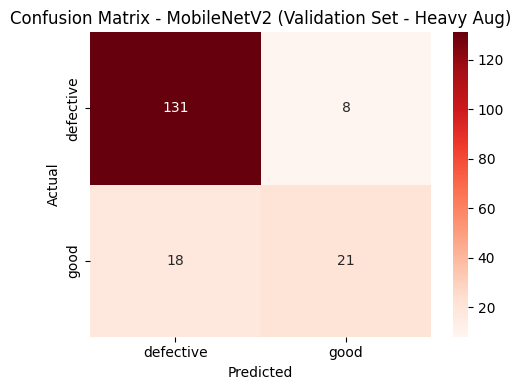

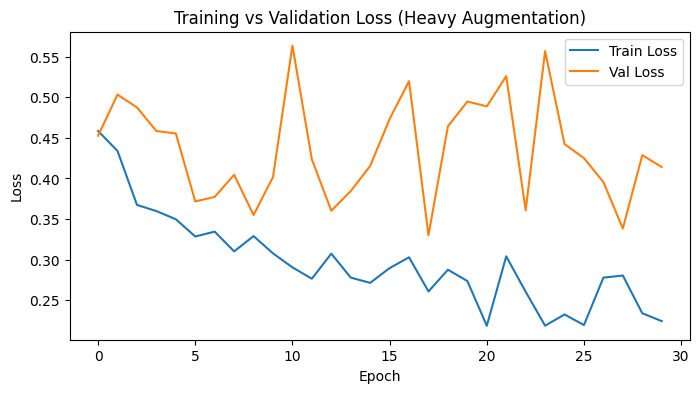

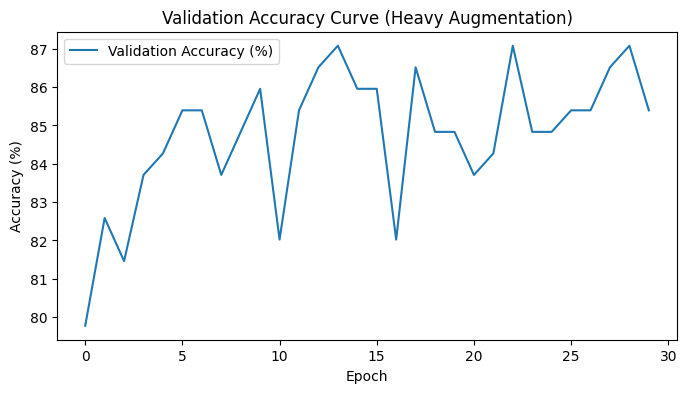


📘 Training summary saved to /content/drive/MyDrive/From Roboflow/All views/models0/MOBIVNET/Heavy_augmentation_direct/training_summary_MobileNetV2_HEAVY_DIRECT.json

=== Final Evaluation on Unseen Test Set ===
--- THIS IS THE REPORT FOR YOUR THESIS ---

=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

   defective       0.88      0.94      0.91       139
        good       0.71      0.56      0.63        39

    accuracy                           0.85       178
   macro avg       0.80      0.75      0.77       178
weighted avg       0.85      0.85      0.85       178


=== CONFUSION MATRIX (Test Set) ===
[[130   9]
 [ 17  22]]

Format: (row = True Label, col = Predicted Label)
          [Pred defective] [Pred good]
[True defective]         130              9
[True good]          17             22


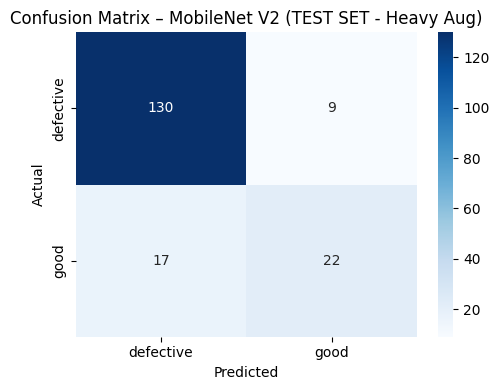


✅ Evaluation complete.


In [ ]:
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset # Import Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os, json
import numpy as np

# [NEW] Import for stratified split
from sklearn.model_selection import train_test_split

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models0/MOBIVNET/Heavy_augmentation_direct"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE = 512
EPOCHS = 30
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET + HEAVY AUGMENTATION [FIXED]
# ============================================================

# [FIX 1: Data Leakage]
# Create two separate transforms.
# Augmentation should ONLY be applied to the training set.
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation and Test sets must NOT be augmented.
transform_test = transforms.Compose([ # Renamed from transform_val
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# [FIX 2: Stratified Split]
# Load dataset metadata first to get labels for splitting
full_dataset_metadata = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = full_dataset_metadata.classes
print(f"\n--- Data Loading ---")
print(f"Classes found: {full_dataset_metadata.class_to_idx}")

# Get all labels (targets) from the dataset for stratification
targets = full_dataset_metadata.targets
indices = list(range(len(targets)))

# 1. First split: (Train + Val) and Test (e.g., 80% / 20%)
train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

# 2. Second split: Train and Val from the (Train + Val) set (e.g., 75% / 25% of the 80% = 60% / 20% of total)
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

# 3. Create two dataset instances with the correct transforms
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_test)

# 4. Create the PyTorch Subset datasets
# Train data uses the AUGMENTED transform
train_data = Subset(train_dataset, train_indices)
# Val and Test data use the CLEAN (non-augmented) transform
val_data = Subset(test_dataset, val_indices)
test_data = Subset(test_dataset, test_indices) # <--- NEW TEST SET

# 5. Create the DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) # <--- NEW TEST LOADER

# Print the final counts
print(f"Total: {len(indices)} images")
print(f"Train: {len(train_data)} images (HEAVY augmentation)")
print(f"Val:   {len(val_data)} images (no augmentation)")
print(f"Test:  {len(test_data)} images (no augmentation)")
print(f"----------------------\n")
print(f"Classes: {class_names}")

# ============================================================
# 3️ MOBILENETV2 CLASSIFIER (DIRECT TRAINING)
# ============================================================
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet.classifier[1] = nn.Linear(1280, NUM_CLASSES)  # Replace final layer
mobilenet = mobilenet.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=1e-4)

# ============================================================
# 4️ TRAINING LOOP
# ============================================================
best_acc = 0.0
train_losses, val_losses, val_accuracies = [], [], [] # Added val_losses
# Define path for best model
best_path = os.path.join(SAVE_DIR, "mobilenetv2_best_HEAVY_direct.pth")

print("\n=== Training MobileNetV2 (HEAVY augmentation) ===")
for epoch in range(EPOCHS):
    mobilenet.train()
    total_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = mobilenet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader) # Renamed avg_loss -> avg_train_loss
    train_losses.append(avg_train_loss)

    # Validation accuracy
    mobilenet.eval()
    val_loss, correct, total = 0, 0, 0 # Added val_loss
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = mobilenet(imgs)
            loss = criterion(outputs, labels) # Calculate val loss
            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader) # Calculate average val loss
    acc = 100 * correct / total
    val_losses.append(avg_val_loss) # Store val loss
    val_accuracies.append(acc)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - TrainLoss: {avg_train_loss:.4f}, ValLoss: {avg_val_loss:.4f}, Val Acc: {acc:.2f}%") # Print val loss too

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save({
            "model_state_dict": mobilenet.state_dict(),
            "epochs": epoch+1,
            "val_acc": acc
        }, best_path)
        print(f"✅ Saved best model (Val Acc: {acc:.2f}%)")

print(f"\n✅ Training complete. Best Validation Accuracy: {best_acc:.2f}%")

# ============================================================
# 5️ EVALUATION (On Validation Set)
# ============================================================
# This section is fine for checking validation data, but it is NOT your final result.
print("\n--- Validation Set Report ---")
mobilenet.eval() # Use the last state of the model for this quick check
all_preds_val, all_labels_val = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = mobilenet(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds_val.extend(preds)
        all_labels_val.extend(labels.numpy())

print("\nClassification Report (Validation):")
print(classification_report(all_labels_val, all_preds_val, target_names=class_names))

cm_val = confusion_matrix(all_labels_val, all_preds_val)
plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - MobileNetV2 (Validation Set - Heavy Aug)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# ============================================================
# 6️ PLOT LOSS / ACCURACY CURVES
# ============================================================
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss") # Plot val loss
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Heavy Augmentation)")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(val_accuracies, label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve (Heavy Augmentation)")
plt.legend()
plt.show()

# ============================================================
# 7️ SAVE TRAINING SUMMARY [UPDATED]
# ============================================================
summary_path = os.path.join(SAVE_DIR, "training_summary_MobileNetV2_HEAVY_DIRECT.json")
summary = {
    "best_val_acc": float(best_acc),
    "img_size": IMG_SIZE,
    "epochs": EPOCHS,
    "augmentation": "Heavy (Rotation ±15°, Flip, ColorJitter, Affine, Perspective)",
    "model": "MobileNetV2 (Direct Training)",
    "classes": class_names,
    "data_split": { # Added
        "train": len(train_data),
        "val": len(val_data),
        "test": len(test_data)
    }
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)

print(f"\n Training summary saved to {summary_path}")


# ============================================================
# 8️ FINAL EVALUATION ON TEST SET [NEW & FIXED]
# ============================================================
print("\n=== Final Evaluation on Unseen Test Set ===")
print("--- THIS IS THE REPORT FOR YOUR THESIS ---")

# 1. Load the BEST saved model
# First, re-define the model architecture
final_model = models.mobilenet_v2(weights=None) # Do not use pretrained weights
final_model.classifier[1] = nn.Linear(1280, NUM_CLASSES)

# Load the saved state dictionary from the best checkpoint
checkpoint = torch.load(best_path)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model = final_model.to(DEVICE)
final_model.eval()

# 2. Collect all predictions and true labels from the TEST set
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for imgs, labels in test_loader: # <-- Use test_loader
        imgs = imgs.to(DEVICE)

        preds = final_model(imgs)
        all_preds_test.append(preds.argmax(1).cpu())
        all_labels_test.append(labels.cpu())

all_preds_test = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()

# 3. Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
# This report will now have valid support for all classes
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

# 4. Generate and print the confusion matrix
print("\n=== CONFUSION MATRIX (Test Set) ===")
cm_test = confusion_matrix(all_labels_test, all_preds_test)
print(cm_test)

print("\nFormat: (row = True Label, col = Predicted Label)")
# Adjust if full_dataset_metadata.class_to_idx shows differently
print(f"          [Pred {class_names[0]}] [Pred {class_names[1]}]")
print(f"[True {class_names[0]}] {cm_test[0,0]:>11} {cm_test[0,1]:>14}")
print(f"[True {class_names[1]}] {cm_test[1,0]:>11} {cm_test[1,1]:>14}")

# 5. Plot the TEST confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix – MobileNet V2 (TEST SET - Heavy Aug)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete.")

## XG BOOST

### no agumenation

Running on cuda
Dataset loaded (NO augmentation): 888 images → Train: 710, Val: 178
Train features: (710, 49152), Val features: (178, 49152)

=== Training XGBoost Classifier on Raw Image Features ===

✅ Validation Accuracy: 79.78%

Classification Report:
              precision    recall  f1-score   support

   defective       0.84      0.90      0.87       136
        good       0.59      0.45      0.51        42

    accuracy                           0.80       178
   macro avg       0.72      0.68      0.69       178
weighted avg       0.78      0.80      0.79       178



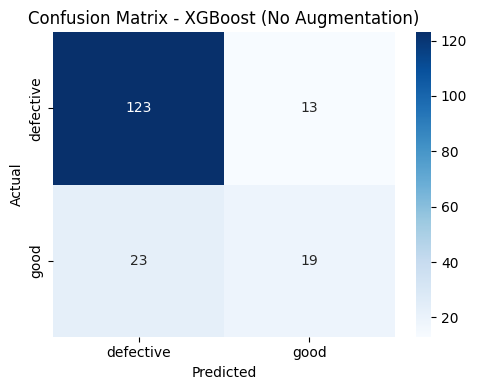


📘 Training summary saved successfully.


In [ ]:


import os, json
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"   # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models/XGBOOST/no_autoencoder"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE   = 128   #  reduced to 128x128 to manage feature dimensionality
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET (NO AUGMENTATION)
# ============================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Dataset loaded (NO augmentation): {len(dataset)} images → Train: {train_size}, Val: {val_size}")

# ============================================================
# 3️ FEATURE EXTRACTION (Flattened RGB pixels)
# ============================================================
def extract_flat_features(loader):
    feats, lbls = [], []
    for imgs, labels in loader:
        imgs_np = imgs.view(imgs.size(0), -1).numpy()  # flatten [B, 3*H*W]
        feats.append(imgs_np)
        lbls.append(labels.numpy())
    return np.vstack(feats), np.hstack(lbls)

train_feats, train_lbls = extract_flat_features(train_loader)
val_feats, val_lbls     = extract_flat_features(val_loader)
print(f"Train features: {train_feats.shape}, Val features: {val_feats.shape}")

# ============================================================
# 4️ XGBOOST CLASSIFIER
# ============================================================
print("\n=== Training XGBoost Classifier on Raw Image Features ===")

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)
xgb.fit(train_feats, train_lbls)

# ============================================================
# 5️ EVALUATION
# ============================================================
val_preds = xgb.predict(val_feats)
acc = accuracy_score(val_lbls, val_preds)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(val_lbls, val_preds, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(val_lbls, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix - XGBoost (No Augmentation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 6️ SAVE MODEL + SUMMARY
# ============================================================
xgb.save_model(os.path.join(SAVE_DIR, "xgboost_model_NOAUG_DIRECT.json"))

summary = {
    "val_acc": float(acc),
    "img_size": IMG_SIZE,
    "augmentation": "None (Baseline)",
    "model_type": "Direct XGBoost (No Autoencoder)"
}
with open(os.path.join(SAVE_DIR, "training_summary_XGBoost_NOAUG_DIRECT.json"), "w") as f:
    json.dump(summary, f, indent=4)

print("\n Training summary saved successfully.")


### light agumenation

Running on cuda
Dataset loaded (Rotation ±5°): 888 images → Train: 710, Val: 178
Classes: ['defective', 'good']
Train features: (710, 49152), Val features: (178, 49152)

=== Training XGBoost Classifier on Raw Image Features (Rotation ±5°) ===

✅ Validation Accuracy: 82.02%

Classification Report:
              precision    recall  f1-score   support

   defective       0.87      0.91      0.89       143
        good       0.55      0.46      0.50        35

    accuracy                           0.82       178
   macro avg       0.71      0.68      0.70       178
weighted avg       0.81      0.82      0.81       178



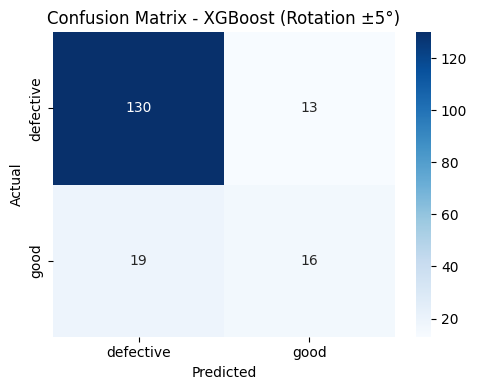


📘 Training summary saved successfully.


In [ ]:


import os, json
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"  # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models/XGBOOST/light_augmentation_noAE"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE   = 128    # ✅ Reduced for XGBoost feature memory
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET + LIGHT AUGMENTATION (Rotation ±5°)
# ============================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor()   # Normalizes to [0,1]
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
train_len = int(0.8 * len(dataset))
val_len   = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset loaded (Rotation ±5°): {len(dataset)} images → Train: {train_len}, Val: {val_len}")
print(f"Classes: {dataset.classes}")

# ============================================================
# 3️ FEATURE EXTRACTION (Flattened RGB Pixels)
# ============================================================
def extract_flat_features(loader):
    feats, lbls = [], []
    for imgs, labels in loader:
        # Flatten images: [B, C, H, W] → [B, C*H*W]
        imgs_np = imgs.view(imgs.size(0), -1).numpy()
        feats.append(imgs_np)
        lbls.append(labels.numpy())
    return np.vstack(feats), np.hstack(lbls)

train_feats, train_lbls = extract_flat_features(train_loader)
val_feats, val_lbls     = extract_flat_features(val_loader)
print(f"Train features: {train_feats.shape}, Val features: {val_feats.shape}")

# ============================================================
# 4️ XGBOOST CLASSIFIER
# ============================================================
print("\n=== Training XGBoost Classifier on Raw Image Features (Rotation ±5°) ===")
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)
xgb.fit(train_feats, train_lbls)

# ============================================================
# 5️ EVALUATION
# ============================================================
val_preds = xgb.predict(val_feats)
acc = accuracy_score(val_lbls, val_preds)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(val_lbls, val_preds, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(val_lbls, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix - XGBoost (Rotation ±5°)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 6️ SAVE MODEL + SUMMARY
# ============================================================
xgb.save_model(os.path.join(SAVE_DIR, "xgboost_model_ROT_noAE.json"))

summary = {
    "val_acc": float(acc),
    "img_size": IMG_SIZE,
    "augmentation": "Rotation Only (±5°)",
    "model_type": "Direct XGBoost (No Autoencoder)",
    "classes": dataset.classes
}
with open(os.path.join(SAVE_DIR, "training_summary_XGBoost_ROT_noAE.json"), "w") as f:
    json.dump(summary, f, indent=4)

print("\n Training summary saved successfully.")


Heavy agumetation

Running on cuda
Dataset loaded (HEAVY augmentation): 888 images → Train: 710, Val: 178
Classes: ['defective', 'good']
Train features: (710, 49152), Val features: (178, 49152)

=== Training XGBoost Classifier (HEAVY augmentation) ===

✅ Validation Accuracy: 86.52%

Classification Report:
              precision    recall  f1-score   support

   defective       0.89      0.95      0.92       143
        good       0.72      0.51      0.60        35

    accuracy                           0.87       178
   macro avg       0.80      0.73      0.76       178
weighted avg       0.86      0.87      0.86       178



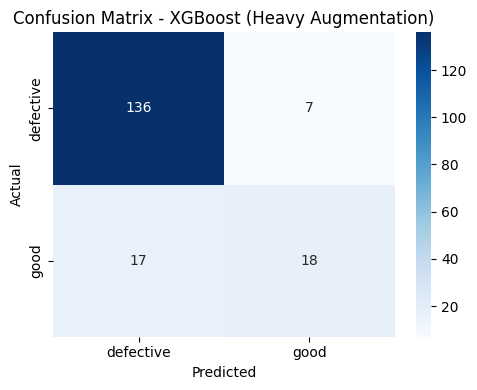


📘 Training summary saved successfully.


In [ ]:


import os, json
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1️ CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/From Roboflow/All views/allviews/dataset"   # defective/, non_defective/
SAVE_DIR = "/content/drive/MyDrive/From Roboflow/All views/models/XGBOOST/Heavy_augmentation_noAE"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 8
IMG_SIZE   = 128   # reduced for feature dimensionality
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# ============================================================
# 2️ DATASET + HEAVY AUGMENTATION (NO NORMALIZATION)
# ============================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.ToTensor()  # Normalizes to [0,1]
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
train_len = int(0.8 * len(dataset))
val_len   = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset loaded (HEAVY augmentation): {len(dataset)} images → Train: {train_len}, Val: {val_len}")
print(f"Classes: {dataset.classes}")

# ============================================================
# 3️ FEATURE EXTRACTION (Flattened RGB Pixels)
# ============================================================
def extract_flat_features(loader):
    feats, lbls = [], []
    for imgs, labels in loader:
        imgs_np = imgs.view(imgs.size(0), -1).numpy()
        feats.append(imgs_np)
        lbls.append(labels.numpy())
    return np.vstack(feats), np.hstack(lbls)

train_feats, train_lbls = extract_flat_features(train_loader)
val_feats, val_lbls     = extract_flat_features(val_loader)
print(f"Train features: {train_feats.shape}, Val features: {val_feats.shape}")

# ============================================================
# 4️ XGBOOST CLASSIFIER
# ============================================================
print("\n=== Training XGBoost Classifier (HEAVY augmentation) ===")

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)
xgb.fit(train_feats, train_lbls)

# ============================================================
# 5️ EVALUATION
# ============================================================
val_preds = xgb.predict(val_feats)
acc = accuracy_score(val_lbls, val_preds)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(val_lbls, val_preds, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(val_lbls, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix - XGBoost (Heavy Augmentation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 6️ SAVE MODEL + SUMMARY
# ============================================================
xgb.save_model(os.path.join(SAVE_DIR, "xgboost_model_HEAVY_noAE.json"))

summary = {
    "val_acc": float(acc),
    "img_size": IMG_SIZE,
    "augmentation": "Heavy (Rotation ±15°, Flip, ColorJitter, Affine, Perspective)",
    "model_type": "Direct XGBoost (No Autoencoder)",
    "classes": dataset.classes
}
with open(os.path.join(SAVE_DIR, "training_summary_XGBoost_HEAVY_noAE.json"), "w") as f:
    json.dump(summary, f, indent=4)

print("\n Training summary saved successfully.")
